In [100]:
#Mount my Google Drive.
from google.colab import drive
drive.mount("/content/drive")
import os
directory = '/content/drive/My Drive/CSC583'
os.chdir(directory)
#Ensure the files are there (in the folder).
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CSC583


In [ ]:
#Key 1 is primary | Key 2 is backup. 
#Your API key.
key1 = ""
key2 = ""

In [ ]:
%%writefile .env
#Your API Key
OPENAI_API_KEY= ""

Overwriting .env


In [ ]:
%%writefile requirements.txt
chromadb==0.5.0
langchain==0.2.0
langchain-community==0.2.0
langchain-experimental==0.0.59
langchain-openai==0.1.7
langdetect==1.0.9
lorem-text==2.1
nbformat>=4.2.0
plotly==5.22.0
pretty-jupyter==1.0
ragas==0.1.8
seaborn==0.13.2
sentence-transformers==3.0.0
spacy>=3.7
textstat==0.7.3
torch==2.5.1
umap-learn==0.5.5

Overwriting requirements.txt


In [ ]:
%pip install -r ./requirements.txt --quiet > /dev/null 2>&1

In [ ]:
#Some important imports.
!pip install -q datasets
import json
import os
import time
import warnings
from collections import Counter
from pathlib import Path
from typing import Dict, List

import chromadb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch
from chromadb import Collection, Documents, EmbeddingFunction, Embeddings
from datasets import Dataset
from dotenv import load_dotenv
from langdetect import detect
from lorem_text import lorem
from ragas import RunConfig, evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_relevancy, answer_correctness)
from spacy.lang.en import English
from textstat import flesch_reading_ease
from tqdm import tqdm
import umap
import nltk
nltk.download('punkt')

from langchain.chains.base import Chain
from langchain.text_splitter import RecursiveCharacterTextSplitter, TextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma, VectorStore
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.language_models import LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage
from langchain.text_splitter import NLTKTextSplitter

#Suppress redundant errors.
import logging
logging.getLogger("langchain_text_splitters.base").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)
from transformers import logging
logging.set_verbosity_error()

#Bert, Rouge, Perplexity.
!pip install -q rouge-score
!pip install -q transformers
from rouge_score import rouge_scorer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
global_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
global_gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
global_rouge_scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2"], use_stemmer=True)

!pip install -q bert-score
from bert_score import score as bert_score

load_dotenv()
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Setting up GPT-3.5-turbo Model.**

*   10,000 RPD.

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo")
response = llm([HumanMessage(content="What is the meaning of life?")])
print(response.content)

The meaning of life is a deeply philosophical question that has been debated throughout history. Different people and cultures have different beliefs about the purpose and meaning of life. Some believe that the meaning of life is to seek happiness and fulfillment, others believe it is to fulfill a higher spiritual purpose, while others believe that life has no inherent meaning and it is up to each individual to create their own meaning and purpose. Ultimately, the meaning of life is a personal and subjective question that each individual must explore and determine for themselves.


# **Load Data.**

In [ ]:
mediaData = pd.read_csv('cleantech_media_dataset_v3_2024-10-28.csv', encoding='utf-8', index_col=0)
print(f'Essay data shape: {mediaData.shape}')
mediaData.head(2)

Essay data shape: (20111, 6)


title        date  author  \
93320      XPeng Delivered ~100,000 Vehicles In 2021  2022-01-02     NaN   
93321  Green Hydrogen: Drop In Bucket Or Big Splash?  2022-01-02     NaN   

                                                 content         domain  \
93320  ['Chinese automotive startup XPeng has shown o...  cleantechnica   
93321  ['Sinopec has laid plans to build the largest ...  cleantechnica   

                                                     url  
93320  https://cleantechnica.com/2022/01/02/xpeng-del...  
93321  https://cleantechnica.com/2022/01/02/its-a-gre...

In [ ]:
evalData = pd.read_csv('cleantech_rag_evaluation_data_2024-09-20.csv', delimiter = ';', encoding='utf-8', index_col=0)
print(f'Essay data shape: {evalData.shape}')
evalData.head(2)

Essay data shape: (23, 5)


question_id                                           question  \
example_id                                                                   
1                     1  What is the innovation behind Leclanché's new ...   
2                     2       What is the EU’s Green Deal Industrial Plan?   

                                                relevant_text  \
example_id                                                      
1           Leclanché said it has developed an environment...   
2           The Green Deal Industrial Plan is a bid by the...   

                                                       answer  \
example_id                                                      
1           Leclanché's innovation is using a water-based ...   
2           The EU’s Green Deal Industrial Plan aims to en...   

                                                  article_url  
example_id                                                     
1           https://www.sgvoice.net/strategy/technology/23...  
2           https://www.sgvoice.net/policy/25396/eu-seeks-...

# **Explorative Data Analysis & Preprocessing.**

In [ ]:
mediaData.describe(include='all').loc[['count', 'unique', 'top', 'freq']]

title        date  author  \
count                  20111       20111     0.0   
unique                 20016         979     NaN   
top     About David J. Cross  2023-06-13     NaN   
freq                      13        1812     NaN   

                                                  content       domain  \
count                                               20111        20111   
unique                                              20068           25   
top     ["By the end of 2022, 37% of single-family hom...  energy-xprt   
freq                                                    3         4181   

                                                      url  
count                                               20111  
unique                                              20111  
top     https://www.pv-magazine.com/2024/10/24/kaust-h...  
freq                                                    1

In [ ]:
mediaData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20111 entries, 93320 to 101431
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    20111 non-null  object 
 1   date     20111 non-null  object 
 2   author   0 non-null      float64
 3   content  20111 non-null  object 
 4   domain   20111 non-null  object 
 5   url      20111 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


In [ ]:
#"author" has all missing values -> Remove.
mediaData = mediaData.drop(columns=["author"])

## **Article Domains.**

In [ ]:
domainCount = mediaData["domain"].value_counts()
domainCount

domain
energy-xprt              4181
pv-magazine              3093
azocleantech             2488
cleantechnica            2089
pv-tech                  1969
thinkgeoenergy           1052
solarpowerportal.co       850
energyvoice               828
solarpowerworldonline     785
solarindustrymag          621
solarquarter              606
rechargenews              573
naturalgasintel           298
iea                       173
energyintel               171
greenprophet              130
greenairnews               59
ecofriend                  55
all-energy                 39
decarbxpo                  20
storagesummit              15
eurosolar                   9
indorenergy                 4
bex-asia                    2
biofuels-news               1
Name: count, dtype: int64

### **Domain Distribution.**

*   Article domains reveals a skewed distribution. Publishers like cleantechnica have a significantly higher representation (2,089 articles), while others like indoenergy have minimal contributions (4 articles). If we proceed with sampling this data, this imbalance should be taken into account.
*   Stratified sampling is the recommended approach to ensure a representative sample across different publishers.

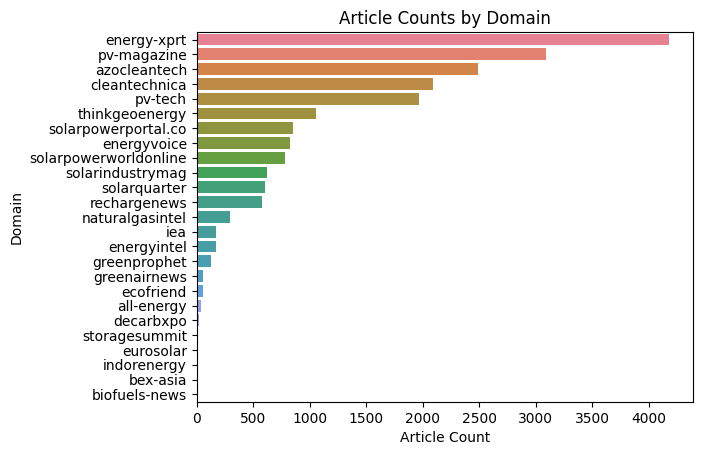

In [ ]:
barplot = sns.barplot(x=domainCount.values,
                      y=domainCount.index,
                      hue=domainCount.index)
barplot.set_title('Article Counts by Domain')
barplot.set_xlabel('Article Count')
barplot.set_ylabel('Domain')
plt.show()

## **Article Dates.**

*   Each article within the dataset is accompanied by a publication date. Let's delve into the temporal range of these articles and investigate any noteworthy patterns in publication trends.
*   While the daily article count appears consistent overall, a significant outlier disrupts the pattern on the 2023-06-13. The cause of this outlier is undetermined, but it could potentially be the date the data was scraped and the default value assigned for missing dates. Since the publication date is not crucial for RAG pipeline, we can remove it.




In [ ]:
mediaData["date"] = pd.to_datetime(mediaData["date"])
timeData = mediaData.groupby("date").size().reset_index()
timeData.columns = ["date","count"]
timeData.describe()

date        count
count                            979   979.000000
mean   2023-05-26 05:11:49.703779328    20.542390
min              2022-01-02 00:00:00     1.000000
25%              2022-09-19 12:00:00     8.000000
50%              2023-05-26 00:00:00    17.000000
75%              2024-01-30 12:00:00    23.000000
max              2024-10-24 00:00:00  1812.000000
std                              NaN    76.837351

### **Date Distribution.**

In [ ]:
#Date with highest article count.
print(timeData[timeData["count"] == timeData["count"].max()])

          date  count
507 2023-06-13   1812


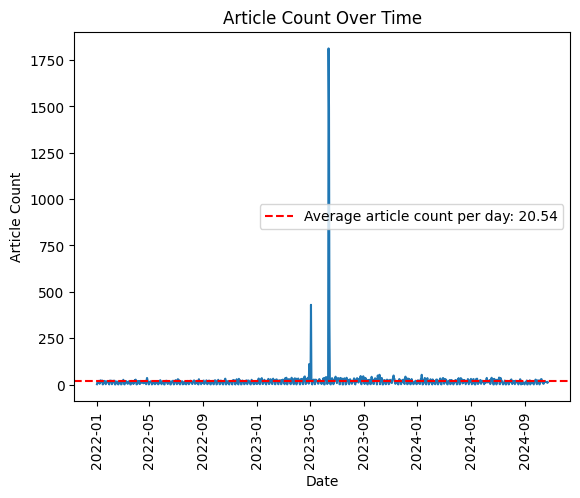

In [ ]:
sns.lineplot(data=timeData, x="date", y="count")
plt.title("Article Count Over Time")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Article Count")
avgCount = timeData["count"].mean()
plt.axhline(avgCount, color='r', linestyle='--', label=f"Average article count per day: {avgCount:.2f}")
plt.legend()
plt.show()

In [ ]:
#Remove "date" column.
mediaData = mediaData.drop(columns=["date"])

## **Article Titles.**

*   As noted in our initial exploration, some articles share identical titles. Here, we'll focus on identifying and handling these duplicate titles to ensure a clean and consistent dataset for our RAG pipeline.
*   Our exploration identified 95 titles that appear multiple times in the dataset. Examples: "Three quarters of power from wind." There are also duplicate contents within duplicate title.



### **Title Distribution.**

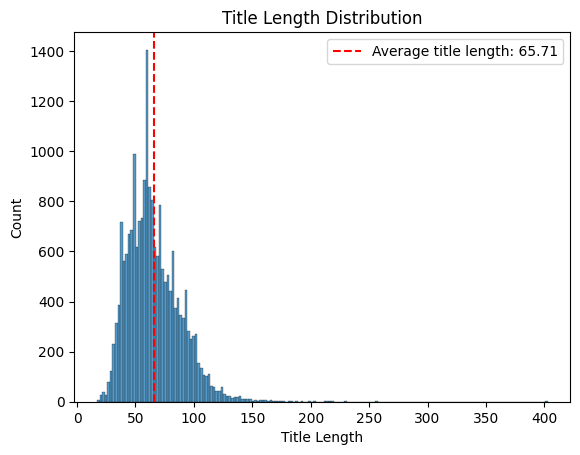

In [ ]:
sns.histplot(mediaData["title"].str.len())
plt.title("Title Length Distribution")
plt.xlabel("Title Length")
plt.ylabel("Count")
avgCount = mediaData["title"].str.len().mean()
plt.axvline(avgCount, color='r', linestyle='--', label=f"Average title length: {avgCount:.2f}")
plt.legend()
plt.show()

In [ ]:
#95 duplicate articles.
mediaData["title"].duplicated().sum()

95

In [ ]:
#Get observation(s) with duplicate title.
duplicateTitle = mediaData[mediaData["title"].duplicated(keep=False)].sort_values("title")
duplicateTitle.head(4)

title  \
105526  'Three quarters of power from wind '   
105527  'Three quarters of power from wind '   
13367   ACWA Power: Quotes, Address, Contact   
22292   ACWA Power: Quotes, Address, Contact   

                                                  content        domain  \
105526  ['Three quarters of Dutch power will come from...  rechargenews   
105527  ['Three quarters of Dutch power will come from...  rechargenews   
13367   ['We use cookies to enhance your experience. B...  azocleantech   
22292   ["By clicking `` Allow All '' you agree to the...  azocleantech   

                                                      url  
105526  https://www.rechargenews.com/wind/three-quarte...  
105527  https://www.rechargenews.com/wind/three-quarte...  
13367   https://www.azocleantech.com/suppliers.aspx?Su...  
22292   https://www.azocleantech.com/Suppliers.aspx?Su...

In [ ]:
#Within duplicate title, there are 6 duplicate contents.
duplicateTitle["content"].duplicated().sum()

6

## **Article Content.**

In [ ]:
def wrapText(text: str, char_per_line=100) -> str:
  '''For better readability, wrap the text at the last space.'''
  if len(text) < char_per_line:
    return text
  else:
    return text[:char_per_line].rsplit(' ', 1)[0] + '\n' + wrapText(text[len(text[:char_per_line].rsplit(' ', 1)[0])+1:], char_per_line)

In [ ]:
#Convert to text (string) instead of list of string.
mediaData['article'] = mediaData['content'].apply(lambda x: ' '.join(eval(x)))
#43 duplicate contents.
print(mediaData["content"].duplicated().sum())

43


### **Remove Redundancy.**

In [ ]:
#Get the beginning 50 characters of the articles, and sort in descending order.
mediaData.article.map(lambda x: x[:50]).value_counts()

article
By clicking `` Allow All '' you agree to the stori    1365
We use cookies to enhance your experience. By cont     865
Sign in to get the best natural gas news and data.     295
Create a free IEA account to download our reports      173
window.dojoRequire ( [ `` mojo/signup-forms/Loader      31
                                                      ... 
My family used to say I had an obsession with Tesl       1
Poland as part of a second phase of offshore wind        1
EOIs are being accepted by KenGen for land leases        1
Avangrid has achieved commercial operation on the        1
Spanish researchers compared two software programs       1
Name: count, Length: 15021, dtype: int64

In [ ]:
#Let see longer text of these prefix.
artifacts = ["By clicking `` Allow All '' you agree to the stori",
             "We use cookies to enhance your experience. By cont",
             "Sign in to get the best natural gas news and data.",
             "Create a free IEA account to download our reports",
             "window.dojoRequire ( [ `` mojo/signup-forms/Loader"]

for artifact in artifacts:
  print(wrapText(mediaData[mediaData.article.str.startswith(artifact)].article.iloc[0][:500]))
  print()

By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site
navigation, analyse site usage and support us in providing free open access scientific content.
More info. Waga Energy is joining forces with Steuben County ( New York, USA) on a Renewable
Natural Gas ( RNG) project at the county’ s Bath landfill. The RNG produced will be injected in the
local grid and used as a biofuel to decarbonize mobility. The Steuben County landfill will be the
first in the US to

We use cookies to enhance your experience. By continuing to browse this site you agree to our use
of cookies. More info. Schneider Electric, the leader in the digital transformation of energy
management and automation, and the world’ s most sustainable corporation 2021 as ranked by
Corporate Knights, today unveiled the first home energy solutions made from ocean plastics. The
market-leading Merten range of sockets and switches made from recycled ocean material delivered in
sustainable packagin

In [ ]:
def remove_scrappingArtifacts(data: pd.DataFrame, column: str) -> pd.DataFrame:
  '''Function replace common prefix with empty string.'''

  textArtifacts = [
        "By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site navigation, analyse site usage and support us in providing free open access scientific content. More info. ",
        "We use cookies to enhance your experience. By continuing to browse this site you agree to our use of cookies. More info. ",
        "Sign in to get the best natural gas news and data. Follow the topics you want and receive the daily emails. Your email address * Your password * Remember me Continue Reset password Featured Content News & Data Services Client Support ",
        "Create a free IEA account to download our reports or subcribe to a paid service. "]

  regexArtifacts = [r"window.dojoRequire \( \[ .*\}\) \}\) "]

  for pattern in textArtifacts:
    data[column] = data[column].str.replace(pattern, '', regex=False)

  for pattern in regexArtifacts:
    data[column] = data[column].str.replace(pattern, '', regex=True)

  return data

In [ ]:
#Data prefix should be much cleaning and 'unique' now.
mediaData2 = remove_scrappingArtifacts(mediaData, "article")
mediaData2.article.map(lambda x: x[:50]).value_counts()

article
Welcome to Edinburgh Instruments’ monthly blog cel    26
Hydrogen Technology Expo & Carbon Capture Technolo    22
Over the last year Kipp & Zonen has received a lot    21
Daily GPI E & P | NGI All News Access The U.S. nat    21
Teledyne Gas & Flame Detection has brought togethe    20
                                                      ..
Antarctic sea ice is a key component of the climat     1
Hy2gen, the global project developer of renewable      1
RT @ matters mx: This is the session about # heati     1
Lehigh Engineering researcher Arup SenGupta has de     1
In this interview, XGS Energy COO Ghazal Izadi dis     1
Name: count, Length: 17541, dtype: int64

### **English Articles.**

In [ ]:
startTime = time.time()
mediaData2["lang"] = mediaData2["article"].map(detect)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Run time: 339.88 seconds


In [ ]:
mediaData2["lang"].value_counts()

lang
en    20106
de        3
ru        1
es        1
Name: count, dtype: int64

In [ ]:
#Let's see a non-English article.
mediaData2[mediaData2["lang"] != "en"]

title  \
82317   Open Letter to Presidents Putin, Biden, Zelens...   
126129  SMS group liefert Prozesstechnologie für das e...   
82320   Internationale Konferenz für Energiespeicher m...   
82321   Presentations, Poster and Photos of the IRES 2022   
101246  Solar + Storage España 2024 – pv magazine Inte...   

                                                  content       domain  \
82317   ['EUROSOLAR, the European Association for Rene...    eurosolar   
126129  ['© SMS group liefert Prozesstechnologie für d...    decarbxpo   
82320   ['Die nun zu Ende gegangene „ Internationale E...    eurosolar   
82321   ['Photos from the IRES ( Copyright EUROSOLAR e...    eurosolar   
101246  ['The event will feature a conference, worksho...  pv-magazine   

                                                      url  \
82317        https://www.eurosolar.de/sektionen/russland/   
126129  https://www.decarbxpo.com/en/News_Media/Magazi...   
82320   https://www.eurosolar.de/2022/09/26/internatio...   
82321   https://www.eurosolar.de/2022/10/20/presentati...   
101246  https://www.pv-magazine.com/pv-magazine-events...   

                                                  article lang  
82317   EUROSOLAR, the European Association for Renewa...   ru  
126129  © SMS group liefert Prozesstechnologie für das...   de  
82320   Die nun zu Ende gegangene „ Internationale Ern...   de  
82321   Photos from the IRES ( Copyright EUROSOLAR e.V...   de  
101246  The event will feature a conference, workshops...   es

In [ ]:
#Only use English articles for this project.
mediaData3= mediaData2[mediaData2["lang"] == "en"]

In [ ]:
#Check for duplication.
duplicateSubset = mediaData3.groupby(["title", "article"]).filter(lambda x: len(x) > 1)
duplicateSubset.shape

(12, 6)

### **Prefix Check.**

*   At this point all common prefix were removed.
*   Spot check for each domain to see if there is still first 100 character prefix 'duplicate'.
*   Note: There are observations with duplicate article content + title. Consider URL differences.
*   Only keep if has different URL and/or Title.


In [ ]:
def remove_prefixArticles(data: pd.DataFrame, prefixLen: int = 200) -> pd.DataFrame:
  '''Check how many article are prefix of another.
     If the first {prefix_len} characters of the article are the same,
     Consider them as a prefix. If an article is a prefix of a longer article:
        Same title and/or URL then we remove it.
        Different titles and/or url, then we keep them.'''

  data["char_len"] = data["article"].map(len)
  data = data.sort_values(by='char_len', ascending=True).reset_index(drop=True)

  #Initialize a list to keep the articles that are not prefixes of others.
  non_prefixArticles = []

  for i, row in data.iterrows():
    isPrefix = False
    article_i = row['article'][:prefixLen]
    title_i = row['title']
    url_i = row['url']

    for j in range(i + 1, len(data)):
      article_j = data.at[j, 'article'][:prefixLen]
      title_j = data.at[j, 'title']
      url_j = data.at[j, 'url']
      if article_i == article_j:
        #If the prefix matches but the titles are different, keep it.
        if title_i != title_j or url_i != url_j:
          continue
        else:
          isPrefix = True
          break
    if not isPrefix:
      non_prefixArticles.append(row)

  print(f"Removed {len(data) - len(non_prefixArticles)} prefix articles")
  return pd.DataFrame(non_prefixArticles)

In [ ]:
def process_byDomain(data, prefixLen=200):
  '''Function to process articles for each domain.'''

  #List to store processed data.
  processedData = []
  for domain in data["domain"].unique():
    print(f"Processing domain: {domain}")

    #Filter data for the current domain.
    domainArticles = data[data["domain"] == domain]
    #Apply remove_prefixArticles to the filtered domain-specific articles.
    cleanedArticles = remove_prefixArticles(domainArticles, prefixLen)
    processedData.append(cleanedArticles)
  combinedData = pd.concat(processedData, ignore_index=True)
  return combinedData

In [ ]:
startTime = time.time()
mediaData4 = process_byDomain(mediaData3)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Processing domain: cleantechnica
Removed 0 prefix articles
Processing domain: pv-magazine
Removed 0 prefix articles
Processing domain: naturalgasintel
Removed 0 prefix articles
Processing domain: energyvoice
Removed 0 prefix articles
Processing domain: solarpowerworldonline
Removed 0 prefix articles
Processing domain: solarindustrymag
Removed 0 prefix articles
Processing domain: thinkgeoenergy
Removed 0 prefix articles
Processing domain: energy-xprt
Removed 0 prefix articles
Processing domain: azocleantech
Removed 0 prefix articles
Processing domain: pv-tech
Removed 0 prefix articles
Processing domain: rechargenews
Removed 0 prefix articles
Processing domain: solarpowerportal.co
Removed 0 prefix articles
Processing domain: energyintel
Removed 0 prefix articles
Processing domain: greenprophet
Removed 0 prefix articles
Processing domain: ecofriend
Removed 0 prefix articles
Processing domain: eurosolar
Removed 0 prefix articles
Processing domain: greenairnews
Removed 0 prefix articles
Pro

In [ ]:
#Train data after clean up has 20,106 observations.
#Only remove 5 non-English articles.
mediaData4.shape

(20106, 7)

## **Characters, Tokens and Words.**

### **Characters.**

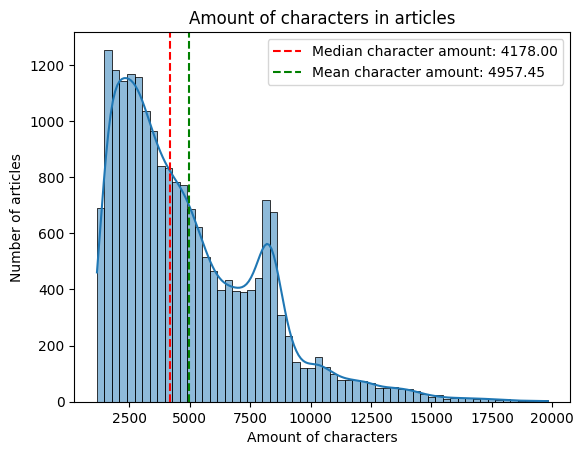

In [ ]:
sns.histplot(mediaData4["article"].map(len), kde=True)
plt.title("Amount of characters in articles")
plt.xlabel("Amount of characters")
plt.ylabel("Number of articles")
median_charLen = mediaData4["article"].map(len).median()
mean_charLen = mediaData4["article"].map(len).mean()
plt.axvline(median_charLen, color='r', linestyle='--', label=f"Median character amount: {median_charLen:.2f}")
plt.axvline(mean_charLen, color='g', linestyle='--', label=f"Mean character amount: {mean_charLen:.2f}")
plt.legend()
plt.show()

### **Words.**

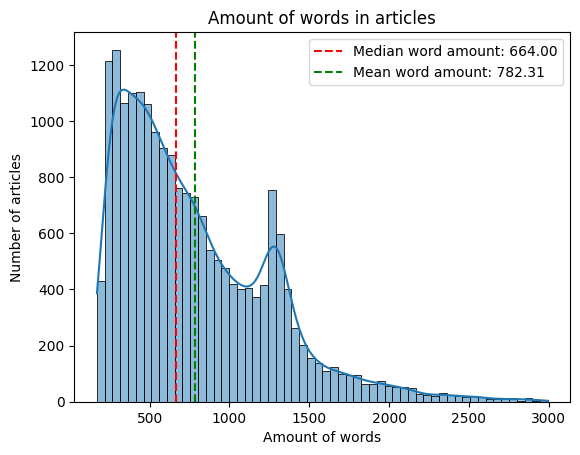

In [ ]:
sns.histplot(mediaData4["article"].map(lambda x: len(x.split())), kde=True)
plt.title("Amount of words in articles")
plt.xlabel("Amount of words")
plt.ylabel("Number of articles")
median_wordLen = mediaData4["article"].map(lambda x: len(x.split())).median()
mean_wordLen = mediaData4["article"].map(lambda x: len(x.split())).mean()
plt.axvline(median_wordLen, color='r', linestyle='--', label=f"Median word amount: {median_wordLen:.2f}")
plt.axvline(mean_wordLen, color='g', linestyle='--', label=f"Mean word amount: {mean_wordLen:.2f}")
plt.legend()
plt.show()

### **Tokens.**

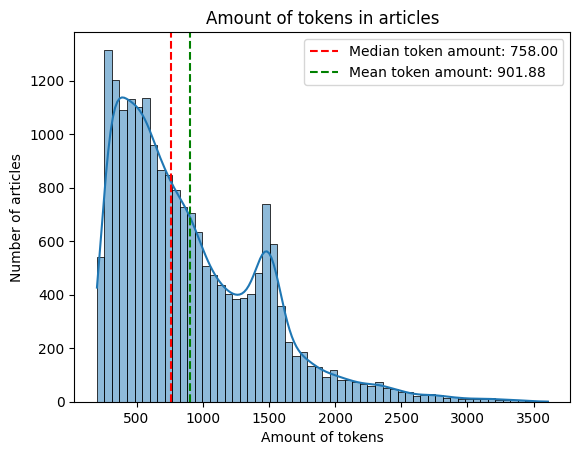

Run time: 73.96 seconds


In [ ]:
startTime = time.time()
nlp = English()
tokenizer = nlp.tokenizer
sns.histplot(mediaData4["article"].map(lambda x: len(tokenizer(x))), kde=True)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

plt.title("Amount of tokens in articles")
plt.xlabel("Amount of tokens")
plt.ylabel("Number of articles")
median_tokenLen = mediaData4["article"].map(lambda x: len(tokenizer(x))).median()
mean_tokenLen = mediaData4["article"].map(lambda x: len(tokenizer(x))).mean()
plt.axvline(median_tokenLen, color='r', linestyle='--', label=f"Median token amount: {median_tokenLen:.2f}")
plt.axvline(mean_tokenLen, color='g', linestyle='--', label=f"Mean token amount: {mean_tokenLen:.2f}")
plt.legend()
plt.show()

Run time: 33.47 seconds


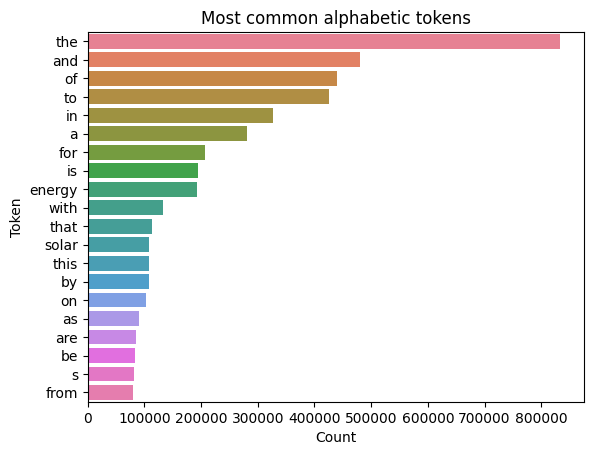

In [ ]:
startTime = time.time()
allTokens = [token.text for article in mediaData4["article"] for token in tokenizer(article)]
#Remove non-alphabetic tokens such as punctuation.
alphaTokens = [token for token in allTokens if token.isalpha()]
alphaTokens = [token.lower() for token in alphaTokens]
alphaToken_counts = Counter(alphaTokens)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

sns.barplot(
    x=[count for token, count in alphaToken_counts.most_common(20)],
    y=[token for token, count in alphaToken_counts.most_common(20)],
    hue=[token for token, count in alphaToken_counts.most_common(20)])

plt.title("Most common alphabetic tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

Run time: 11.20 seconds


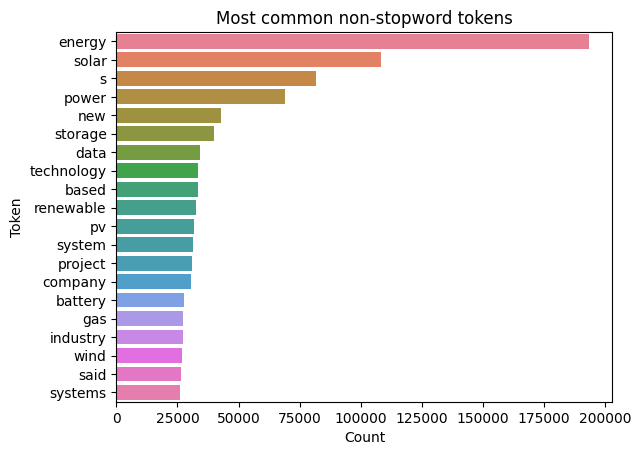

In [ ]:
#Remove stopwords such as 'the', 'a', 'and'.
startTime = time.time()
non_stopTokens = [token for token in alphaTokens if not nlp.vocab[token].is_stop]
non_stopToken_counts = Counter(non_stopTokens)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

sns.barplot(
    x=[count for token, count in non_stopToken_counts.most_common(20)],
    y=[token for token, count in non_stopToken_counts.most_common(20)],
    hue=[token for token, count in non_stopToken_counts.most_common(20)])

plt.title("Most common non-stopword tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

## **Flesch Reading Ease Score.**

Run time: 37.29 seconds


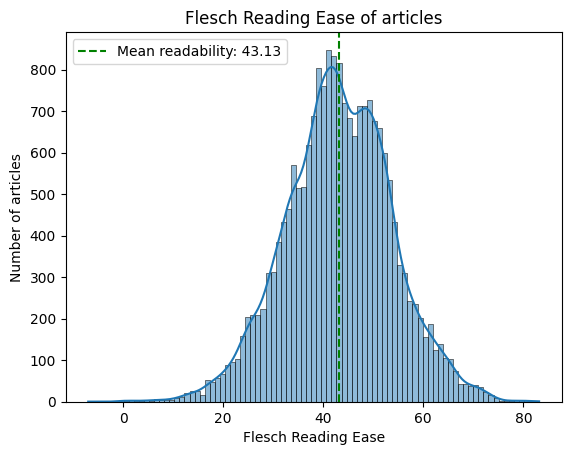

In [ ]:
startTime = time.time()
mediaData4["readability"] = mediaData4["article"].apply(flesch_reading_ease)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")
sns.histplot(mediaData4["readability"], kde=True)

plt.title("Flesch Reading Ease of articles")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Number of articles")
meanReadability = mediaData4["readability"].mean()
plt.axvline(meanReadability, color='g', linestyle='--', label=f"Mean readability: {meanReadability:.2f}")
plt.legend()
plt.show()

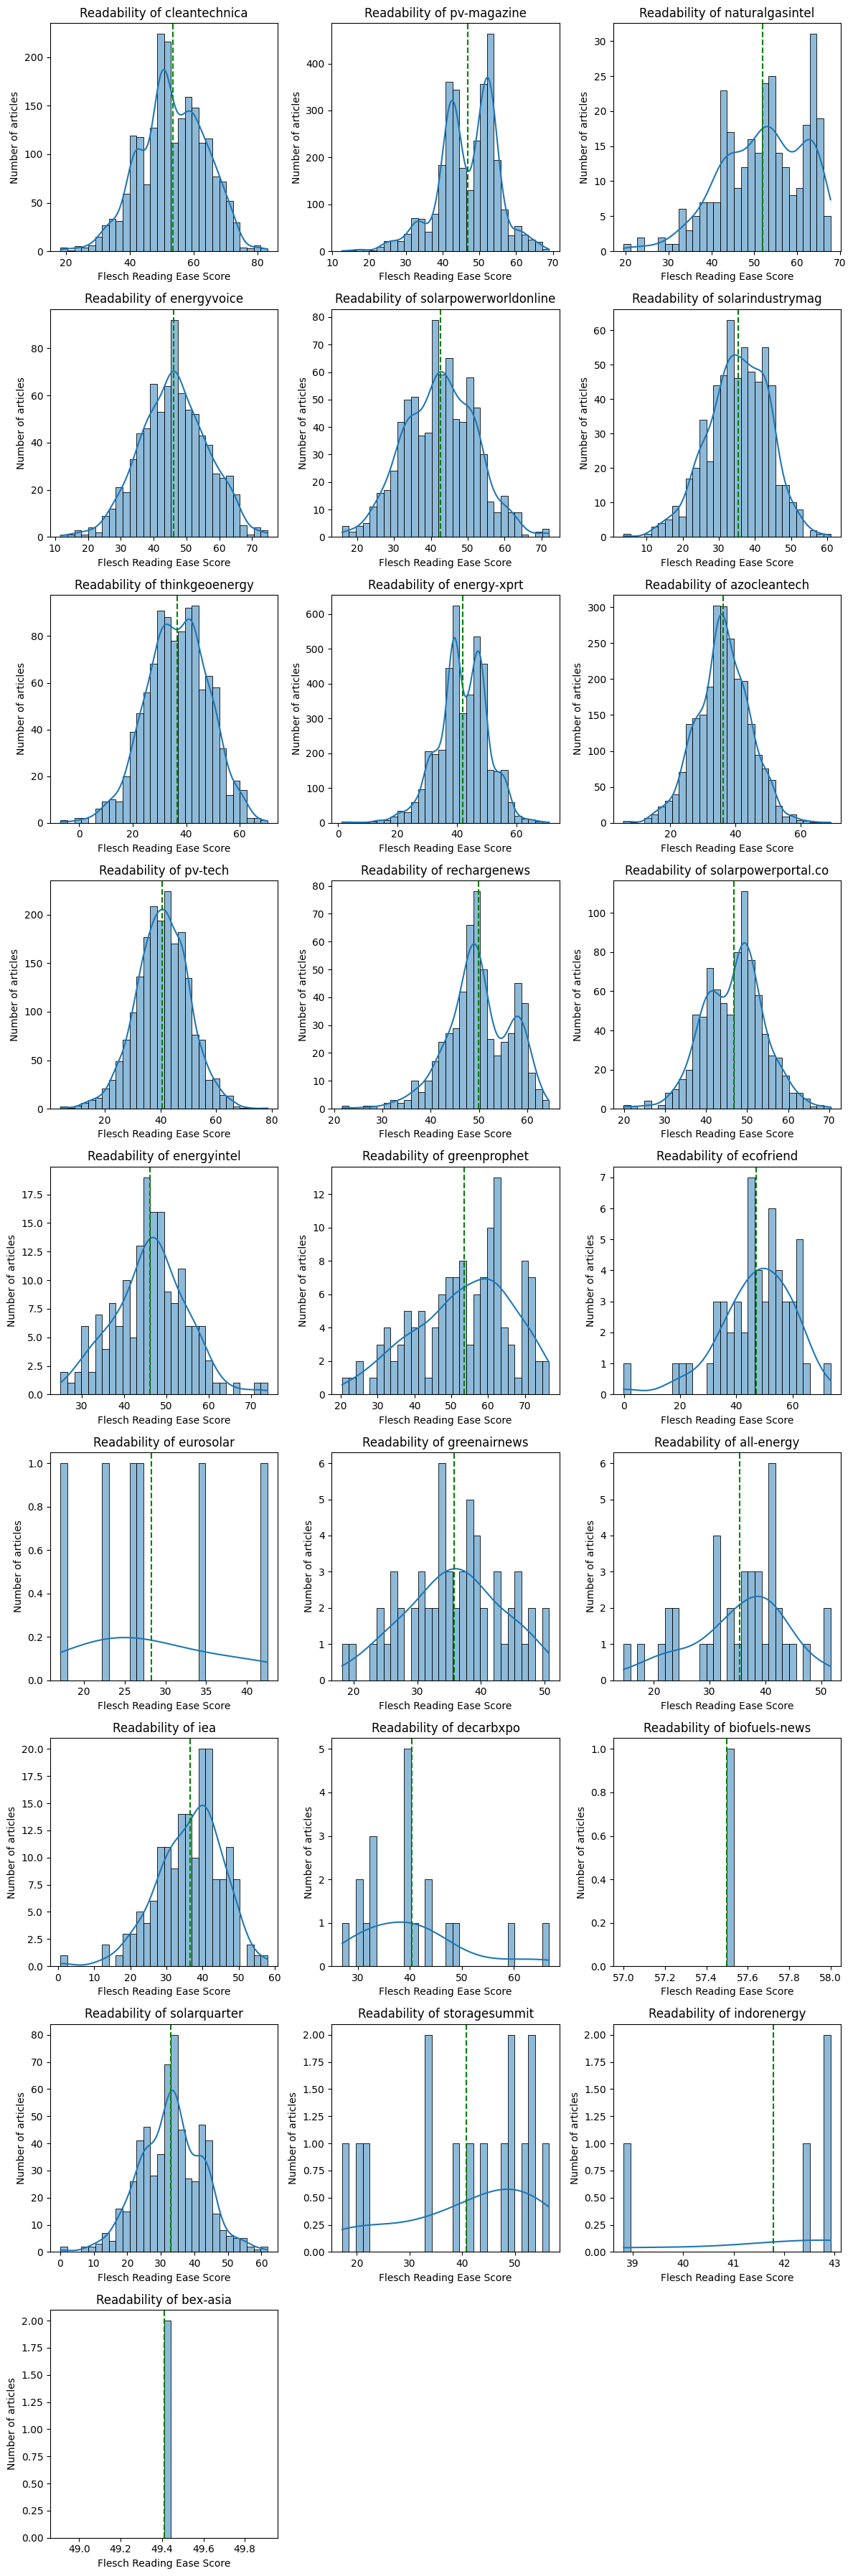

Run time: 7.28 seconds


In [ ]:
startTime = time.time()
domains = mediaData4["domain"].unique()
#Setup the subplots based on the number of domains.
plots_perRow = 3
numRows = (len(domains) + 2) // plots_perRow
plotHeight = 4
fig, axes = plt.subplots(numRows, plots_perRow, figsize=(plotHeight * plots_perRow, plotHeight * numRows))
axes = axes.flatten()

#Plot for each domain.
for i, domain in enumerate(domains):
  domainArticles = mediaData4[mediaData4["domain"] == domain]
  sns.histplot(domainArticles["readability"], kde=True, ax=axes[i], bins=30)
  axes[i].set_title(f'Readability of {domain}')
  axes[i].set_xlabel('Flesch Reading Ease Score')
  axes[i].set_ylabel("Number of articles")
  meanReadability = domainArticles["readability"].mean()
  axes[i].axvline(meanReadability, color='g', linestyle='--', label=f"Mean readability: {meanReadability:.2f}")

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

# **Evaluation Data.**

In [ ]:
evalData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 1 to 23
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_id    23 non-null     int64 
 1   question       23 non-null     object
 2   relevant_text  23 non-null     object
 3   answer         23 non-null     object
 4   article_url    23 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.1+ KB


In [ ]:
evalData.rename(columns={"article_url": "url"}, inplace=True)
evalData.drop(columns=["question_id"], inplace=True)

## **Character Length Distribution.**

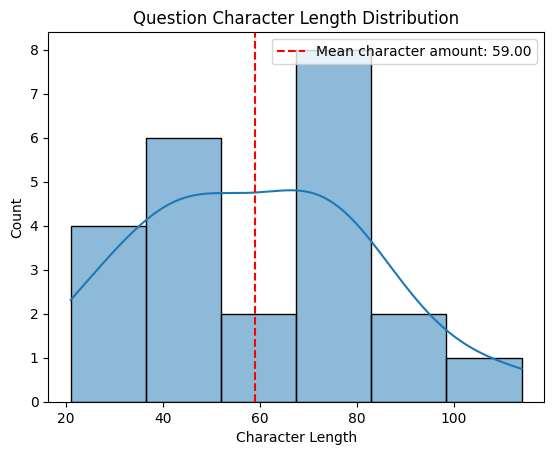

In [ ]:
sns.histplot(evalData["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_charLen = evalData["question"].map(len).mean()
plt.axvline(mean_charLen, color='r', linestyle='--', label=f"Mean character amount: {mean_charLen:.2f}")
plt.legend()
plt.show()

## **Article in Evaluation but not in Training Data.**

In [ ]:
missingArticles = evalData.copy()
missingArticles["url"] = missingArticles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))
missingArticles = missingArticles[~evalData["url"].isin(mediaData4["url"])]
print(missingArticles.shape)

(4, 4)


### **Spot Check.**

*   There are only four articles in evaluation data that their URLs do not exist in training data.
*   Two missing articles have the same URLs.

In [ ]:
checkURL = ["https://www.sgvoice.energyvoice.com/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density/",
            "https://www.sgvoice.energyvoice.com/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan",
            "https://www.pv-magazine.com/2021/01/15/germanium-based-solar-cell-tech-for-agrivoltaics/#respond"]

for url in checkURL:
  #Check if the URL exists in original mediaData.
  urlExists = mediaData4[mediaData4["url"] == url]

  if not urlExists.empty:
    print("The URL exists. Here are the matching rows:")
    print(urlExists)
  else:
    print("The URL does not exist.")

The URL does not exist.
The URL does not exist.
The URL does not exist.


### **Further Check with URL Normalization.**

In [ ]:
def normalizeURL(url: str) -> str:
  '''Convert URL string without common characters.'''
  url = url.replace("https://", "")
  url = url.replace("http://", "")
  url = url.replace("www.", "")
  url = url.rstrip("/")
  return url

mediaData4["url_short"] = mediaData4["url"].map(normalizeURL)
evalData["url_short"] = evalData["url"].map(normalizeURL)

missingArticles = evalData.copy()
missingArticles["url_short"] = missingArticles["url_short"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))
for idx, row in missingArticles.iterrows():
  urlShort = row["url_short"]
  #Check if the url_short exists in mediaData4['url'].
  urlExists = mediaData4[mediaData4["url"].str.contains(urlShort, na=False)]
  if not urlExists.empty:
    #Replace the current 'url' with the first match in mediaData4.
    evalData.at[idx, "url"] = urlExists["url"].iloc[0]
missingArticles = missingArticles[~evalData["url"].isin(mediaData4["url"])]
missingArticles.shape

(1, 5)

In [ ]:
missingArticles

question  \
example_id                                                      
23          Which has the higher absorption coefficient fo...   

                                                relevant_text  \
example_id                                                      
23          We chose amorphous germanium instead of amorph...   

                         answer  \
example_id                        
23          amorphous germanium   

                                                          url  \
example_id                                                      
23          https://www.pv-magazine.com/2021/01/15/germani...   

                                                    url_short  
example_id                                                     
23          pv-magazine.com/2021/01/15/germanium-based-sol...

### **Spot Check.**

*   This one only article do not have URL exists in training data.

In [ ]:
checkURL = ["pv-magazine.com/2021/01/15/germanium-based-solar-cell-tech-for-agrivoltaics/"]

for url in missingArticles["url_short"]:
  #Check if the URL exists in original mediaData.
  urlExists = mediaData4[mediaData4["url"].str.contains(url, na=False)]
  if not urlExists.empty:
    print("The URL exists")
  else:
    print("The URL does not exist.")

The URL does not exist.


### **Finding Most Related Article.**

*   Since this article "germanium-based-solar-cell-tech-for-agrivoltaics" does not exist in training data -> Look for the most related one by key words.

In [ ]:
substrings = ["amorphous", "solar cell", "silicon", "absorption", "agrivoltaics"]

#Filter the mediaData4 for rows where 'content' contains the substring.
filteredContent = mediaData4[mediaData4["content"].apply(lambda x: all(sub in x for sub in substrings) if isinstance(x, str) else False)]

#Print the matching URLs
if not filteredContent.empty:
    print("URLs containing the substring:")
    print(filteredContent["content"])
    print(filteredContent["url"])
else:
    print(f"No URLs containing the substring '{substrings}' were found in the DataFrame.")

URLs containing the substring:
4559    ['Spanish researchers have developed a new mod...
Name: content, dtype: object
4559    https://www.pv-magazine.com/2022/01/13/modelin...
Name: url, dtype: object


# **Subsampling.**

In [ ]:
#There are 4 questions, of which each 2 have same URLs.
urlCount = evalData["url"].value_counts()
len(urlCount)

21

In [ ]:
eval_mediaData = mediaData4[mediaData4["url"].isin(evalData["url"])]
eval_mediaData = pd.concat([eval_mediaData, mediaData4.loc[[4559]]])
eval_mediaData.shape

(21, 9)

In [ ]:
print(eval_mediaData["url"].unique().shape)
print(evalData["url"].unique().shape)

(21,)
(21,)


In [ ]:
def doStratification(data: pd.DataFrame, column: str, sample_size: int, seed: int = 1997) -> pd.DataFrame:
  '''Stratify the data based on column.'''
  resData = data.copy()
  indx = data.groupby(column, group_keys=False)[column].apply(lambda x: x.sample(n=int(sample_size/len(data) * len(x)), random_state=seed)).index.to_list()
  return resData.loc[indx]

In [ ]:
sampleData = doStratification(mediaData4, "domain", 1000, 1997)
#If the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls.
sampleData = sampleData[~sampleData["url"].isin(eval_mediaData["url"])]
sampleData = pd.concat([sampleData, eval_mediaData])
sampleData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, 19283 to 4559
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        1007 non-null   object 
 1   content      1007 non-null   object 
 2   domain       1007 non-null   object 
 3   url          1007 non-null   object 
 4   article      1007 non-null   object 
 5   lang         1007 non-null   object 
 6   char_len     1007 non-null   int64  
 7   readability  1007 non-null   float64
 8   url_short    1007 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 78.7+ KB


## **Domain Distribution Post Sampling.**

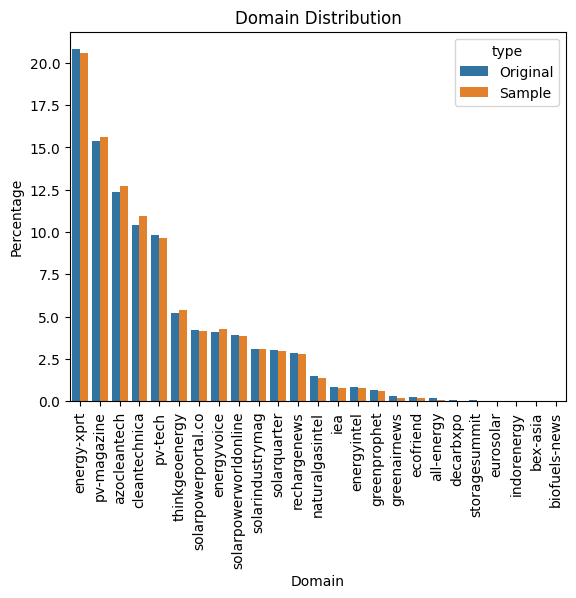

Run time: 0.43 seconds


In [ ]:
startTime = time.time()
original_domainCounts = mediaData4["domain"].value_counts().to_frame()
original_domainCounts = original_domainCounts / original_domainCounts.sum() * 100
domain_countsData = original_domainCounts.copy()
domain_countsData["type"] = "Original"

sample_domainCounts = sampleData["domain"].value_counts().to_frame()
sample_domainCounts = sample_domainCounts / sample_domainCounts.sum() * 100
sample_domainCounts["type"] = "Sample"

domain_countsData = pd.concat([domain_countsData, sample_domainCounts])
sns.barplot(x=domain_countsData.index,
            y=domain_countsData["count"],
            hue=domain_countsData["type"])
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

# **Chunking.**

In [ ]:
def get_loremText(numChars: int) -> str:
  '''Generate a string of random text with a specified number of characters.'''
  expected_avg_wordLen = 3
  text = lorem.words(numChars // expected_avg_wordLen)
  return text[:numChars]

In [ ]:
print(wrapText(get_loremText(256)))

voluptas corporis sed doloremque possimus quia earum assumenda expedita cum consequuntur facilis
tempore neque dolores quam nesciunt deleniti tempora magni vitae quisquam hic non enim recusandae
ullam autem excepturi quis consectetur aspernatur culpa sint 


# **Creating the Chunks.**

In [ ]:
def get_recursiveSplitter(chunk_size: int, chunk_overlap: int) -> TextSplitter:
  '''Splits text into smaller chunks.'''
  return RecursiveCharacterTextSplitter(chunk_size=chunk_size,
                                        chunk_overlap=chunk_overlap,
                                        separators=["\n\n", "\n", "(?<=\. )", " ", ""],
                                        length_function=len)

In [ ]:
def get_nltkSplitter(chunk_size: int, chunk_overlap: int) -> TextSplitter:
  '''Splits text into smaller chunks using NLTKTextSplitter.'''
  return NLTKTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

In [ ]:
#The recursive splitter mainly relies on newlines, are there even any? No, so it will focus on sentences.
sampleData["article"].map(lambda x: x.count("\n")).sum()

0

In [ ]:
#GPU.
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"
model_kwargs = {'device': device, "trust_remote_code": True}
model_kwargs

{'device': 'cuda', 'trust_remote_code': True}

# **Embedding Models.**

In [ ]:
embeddingModels = {"mini": HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs=model_kwargs),
                   "bge-m3": HuggingFaceEmbeddings(model_name="BAAI/bge-m3", model_kwargs=model_kwargs),
                   "gte": HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-base-en-v1.5", model_kwargs=model_kwargs)}

In [ ]:
#NLTK splitters.
nltk256_splitter = get_nltkSplitter(256, 64)
nltk1024_splitter = get_nltkSplitter(1024, 128)
#Recursive splitters.
recursive256_splitter = get_recursiveSplitter(256, 64)
recursive1024_splitter = get_recursiveSplitter(1024, 128)
semanticSplitter = SemanticChunker(embeddingModels["mini"], breakpoint_threshold_type="percentile")
splitters = {"recursive_256": recursive256_splitter,
             "recursive_1024": recursive1024_splitter,
             "semantic": semanticSplitter,
             "nltk_256": nltk256_splitter,
             "nltk_1024": nltk1024_splitter}

In [ ]:
def chunkDocuments(data: pd.DataFrame, text_splitter: TextSplitter) -> List[Document]:
  '''Chunk documents from a DataFrame and add metadata,
     including a master running ID and an in-document chunk ID (0-based index).
    Para: data - Containing documents with 'article' and 'title' columns.
          text_splitter: A text splitter to create chunks.
    Returns: List of Document objects with metadata.'''

  chunks = []
  #Master running ID for all chunks.
  runningID = 0

  for _, row in tqdm(data.iterrows(), total=len(data)):
    articleContent = row['article']
    title = row['title']
    #Combine title and content.
    fullText = title + ": " + articleContent
    charChunks = text_splitter.split_text(fullText)

    #Assign in-document chunk ID.
    for in_doc_chunkID, chunk in enumerate(charChunks):
      runningID += 1
      #Add metadata to the chunk.
      metadata = {'title': row['title'],
                  'url': row['url'],
                  'domain': row['domain'],
                  'id': runningID,
                  'in_doc_chunk_id': in_doc_chunkID}
      chunks.append(Document(page_content=chunk, metadata=metadata))
  return chunks

In [ ]:
def getChunks(data: pd.DataFrame, text_splitter: TextSplitter) -> List[Document]:
  '''Generate chunks.'''
  chunks = chunkDocuments(data, text_splitter)
  print(f"Generated {len(chunks)} chunks in memory.")
  return chunks

## **Chunking Using Sample Data.**

In [ ]:
nltk.download('punkt_tab')
chunks = {}
startTime = time.time()
for splitterName, splitter in splitters.items():
  print(f"Processing splitter: {splitterName}")
  chunks[splitterName] = getChunks(sampleData, splitter)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Processing splitter: recursive_256


100%|██████████| 1007/1007 [00:01<00:00, 577.66it/s]


Generated 26833 chunks in memory.
Processing splitter: recursive_1024


100%|██████████| 1007/1007 [00:01<00:00, 671.04it/s]


Generated 6066 chunks in memory.
Processing splitter: semantic


100%|██████████| 1007/1007 [01:33<00:00, 10.82it/s]


Generated 3343 chunks in memory.
Processing splitter: nltk_256


100%|██████████| 1007/1007 [00:01<00:00, 621.85it/s]


Generated 25259 chunks in memory.
Processing splitter: nltk_1024


100%|██████████| 1007/1007 [00:01<00:00, 801.08it/s]

Generated 6154 chunks in memory.
Run time: 99.23 seconds


# **Analyzing the Chunks.**

In [ ]:
for splitterName, splitterChunks in chunks.items():
  print(f"{splitterName} chunks:")
  print(wrapText(splitterChunks[0].page_content, char_per_line=150))
  print()

In [ ]:
def plot_chunkLengths(chunks: List[Document], title: str):
  '''Plot the distribution of chunk lengths.'''
  plt.figure(figsize=(6, 4))
  sns.histplot([len(chunk.page_content) for chunk in chunks], kde=True)
  plt.title(title)
  plt.xlabel("Chunk length")
  plt.ylabel("Number of chunks")
  median_chunkLen = np.median([len(chunk.page_content) for chunk in chunks])
  mean_chunkLen = np.mean([len(chunk.page_content) for chunk in chunks])
  plt.axvline(median_chunkLen, color='r', linestyle='--', label=f"Median chunk length: {median_chunkLen:.2f}")
  plt.axvline(mean_chunkLen, color='g', linestyle='--', label=f"Mean chunk length: {mean_chunkLen:.2f}")
  plt.legend()
  plt.show()

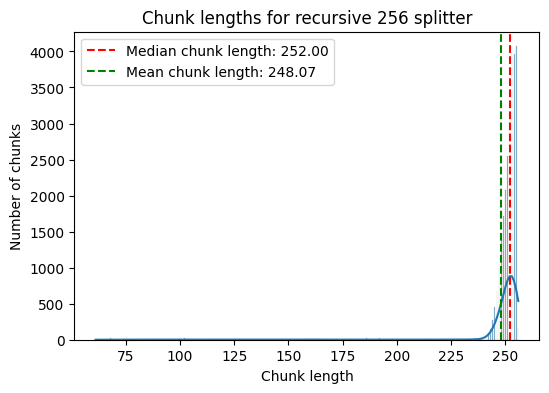

In [ ]:
plot_chunkLengths(chunks["recursive_256"], "Chunk lengths for recursive 256 splitter")

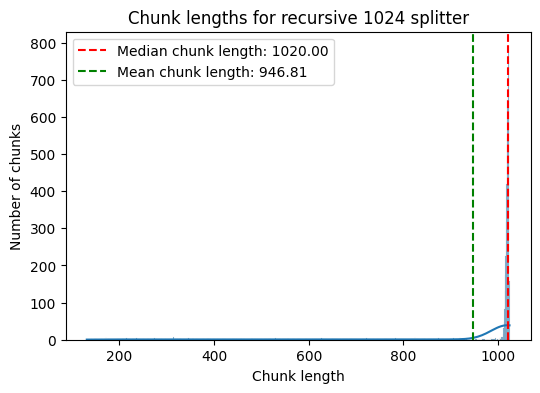

In [ ]:
plot_chunkLengths(chunks["recursive_1024"], "Chunk lengths for recursive 1024 splitter")

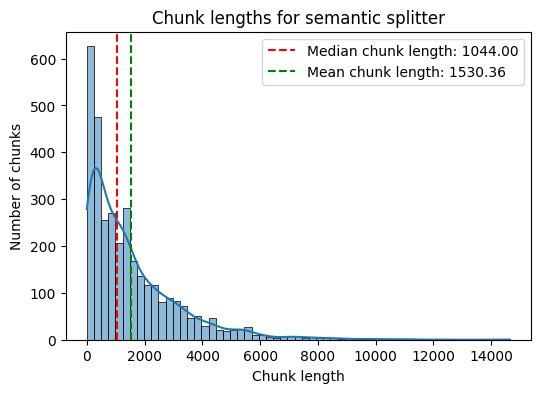

In [ ]:
plot_chunkLengths(chunks["semantic"], "Chunk lengths for semantic splitter")

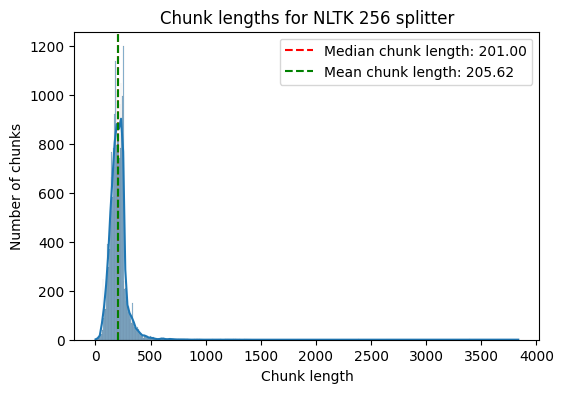

In [ ]:
plot_chunkLengths(chunks["nltk_256"], "Chunk lengths for NLTK 256 splitter")

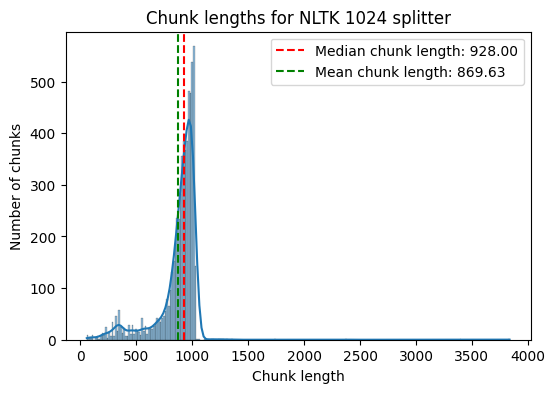

In [ ]:
plot_chunkLengths(chunks["nltk_1024"], "Chunk lengths for NLTK 1024 splitter")

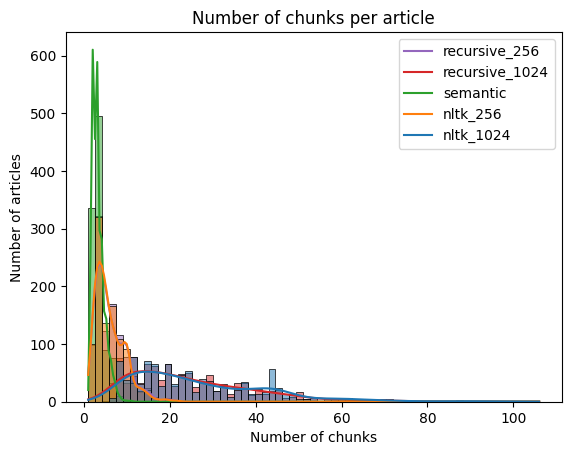

In [ ]:
chunks_perArticle = {splitterName: Counter([chunk.metadata["title"] for chunk in chunks]) for splitterName, chunks in chunks.items()}
counts = {splitterName: [count for title, count in chunkCounts.items()] for splitterName, chunkCounts in chunks_perArticle.items()}
sns.histplot(counts, kde=True)
plt.title("Number of chunks per article")
plt.xlabel("Number of chunks")
plt.ylabel("Number of articles")
plt.legend(chunks_perArticle.keys())
plt.show()

# **Generating Embeddings.**

In [ ]:
class CustomChromadbEmbeddingFunction(EmbeddingFunction):
  def __init__(self, model) -> None:
    super().__init__()
    self.model = model
  def _embed(self, l):
    return [self.model.embed_query(x) for x in l]
  def embed_query(self, query):
    return self._embed([query])
  def __call__(self, input: Documents) -> Embeddings:
    embeddings = self._embed(input)
    return embeddings

In [ ]:
chroma_embedding_functions = {
    "mini": CustomChromadbEmbeddingFunction(embeddingModels["mini"]),
    "bge-m3": CustomChromadbEmbeddingFunction(embeddingModels["bge-m3"]),
    "gte": CustomChromadbEmbeddingFunction(embeddingModels["gte"])}
for name, embedding_function in chroma_embedding_functions.items():
    sample = embedding_function(["Hello, world!"])[0][:5]
    print(f"{name} embedding sample: {sample}")

mini embedding sample: [0.034922659397125244, 0.018830055370926857, -0.017854733392596245, 0.00013884309737477452, 0.0740736573934555]
bge-m3 embedding sample: [-0.01615564152598381, 0.02699340134859085, -0.042583223432302475, 0.013542215339839458, -0.01935463398694992]
gte embedding sample: [0.0378943607211113, 0.3469235897064209, -0.20471279323101044, -0.21238654851913452, -0.49100807309150696]


In [ ]:
class DocumentEmbedding():
  def __init__(self, document: Document, text_embedding: List[float]) -> None:
    self.document = document
    self.text_embedding = text_embedding

  def to_dict(self) -> Dict:
    return {"document": self.document.dict(),
            "text_embedding": self.text_embedding}

  @classmethod
  def from_dict(cls, d: Dict) -> "DocumentEmbedding":
    return cls(document=Document(**d["document"]),
               text_embedding=d["text_embedding"])

In [ ]:
def get_embeddings_in_memory(embedding_function: EmbeddingFunction, chunks: List[Document]) -> List[DocumentEmbedding]:
  '''Generate embeddings in memory without storing them on disk.'''

  print(f"Generating embeddings for {len(chunks)} chunks...")
  embeddings = []
  for chunk in tqdm(chunks):
    text_embedding = embedding_function([chunk.page_content])[0]
    embedding = DocumentEmbedding(
            document=chunk,
            text_embedding=text_embedding)
    embeddings.append(embedding)
  print(f"Generated {len(embeddings)} embeddings in memory.")
  return embeddings

In [ ]:
startTime = time.time()
#15 embeddings.
embeddings = {}
for embedding_name, embedding_function in chroma_embedding_functions.items():
  for splitter_name, splitter_chunks in chunks.items():
    key = f"{embedding_name}_{splitter_name}"
    print(f"Processing embeddings for: {key}")
    embeddings[key] = get_embeddings_in_memory(embedding_function, splitter_chunks)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

# **Storing the Embeddings in ChromaDB.**

In [ ]:
#Initialize an in-memory Chroma client.
chroma_client = chromadb.EphemeralClient()

In [ ]:
def get_or_createCollection(name: str, embedding_function: EmbeddingFunction, embeddings: List[DocumentEmbedding], batch_size: int = 128) -> Collection:
  '''Create or retrieve a Chroma collection, managing it entirely in memory.'''

  collection = chroma_client.get_or_createCollection(
        name=name,
        #Configure to use cosine distance instead of the default L2.
        metadata={"hnsw:space": "cosine"},
        embedding_function=embedding_function)

  #Add embeddings to the collection if it is empty.
  if collection.count() == 0:
    for i in tqdm(range(0, len(embeddings), batch_size), desc=f"Adding to {name}"):
      batch = embeddings[i:i+batch_size]
      collection.add(
            documents=[embedding.document.page_content for embedding in batch],
            embeddings=[embedding.text_embedding for embedding in batch],
            ids=[str(embedding.document.metadata["id"]) for embedding in batch],
            metadatas=[embedding.document.metadata for embedding in batch])
  return collection

In [ ]:
collections = {}
for collection_name, current_embeddings in embeddings.items():
  print(f"Processing collection: {collection_name}")
  collection = get_or_createCollection(
        collection_name,
        chroma_embedding_functions[collection_name.split("_")[0]],
        current_embeddings)
  collections[collection_name] = collection
  print(f"Collection {collection_name} has {collection.count()} documents.")

In [ ]:
#Select a specific collection to query.
selectedCollection = collections["gte_nltk_256"]
#Query the selected collection.
results = selectedCollection.query(query_texts=["Clean Energy"], n_results=3)

#Display query results.
for doc in results["documents"][0]:
    print(wrapText(doc))
    print()

This cutting-edge technology merges battery storage with hydrogen fuel cells, offering consumers a
dependable and cost-efficient solution for transitioning to a 100% clean electricity grid.

By championing this initiative, the United States is poised to transition significantly towards
clean energy resources, effectively curbing the nation’ s greenhouse gas emissions.

This approach not only reduces reliance on non-renewable photovoltaic materials but also integrates
biological systems into energy production, promising a new dimension of sustainability.



# **Analyzing the Embedding Space.**

In [ ]:
def getVectors_fromCollection(collection: Collection):
  '''Retrieve all embeddings from a collection.'''
  storedChunks = collection.get(include=["documents", "metadatas", "embeddings"])
  return np.array(storedChunks["embeddings"])

def getVectors_byDomain(collection: Collection, domain: str):
  '''Retrieve embeddings for a specific domain from a collection.'''
  storedChunks = collection.get(include=["documents", "metadatas", "embeddings"])
  metadatas = storedChunks["metadatas"]
  indices = [str(metadata["id"]) for metadata in metadatas if metadata["domain"] == domain]
  return collection.get(include=["embeddings"], ids=indices)["embeddings"]

def fitUMAP(vectors: np.ndarray):
  '''Fit a UMAP model to the provided vectors.'''
  return umap.UMAP().fit(vectors)

def projectEmbeddings(embeddings, umap_transform):
  '''Project embeddings into a lower-dimensional space using a pre-fitted UMAP model.'''
  return umap_transform.transform(embeddings)

In [ ]:
startTime = time.time()
vectors = getVectors_fromCollection(selectedCollection)
print(f"Original shape: {vectors.shape}")
umapTransform = fitUMAP(vectors)
vectorsProjections = projectEmbeddings(vectors, umapTransform)
print(f"Projected shape: {vectorsProjections.shape}")
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Original shape: (25259, 768)
Projected shape: (25259, 2)
Run time: 44.05 seconds


In [ ]:
startTime = time.time()
fig = px.scatter(x=vectorsProjections[:, 0], y=vectorsProjections[:, 1])
fig.update_layout(width=600, height=400)
fig.show()
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Run time: 0.34 seconds


In [ ]:
startTime = time.time()
fig = go.Figure()
for domain in sampleData["domain"].unique():
  domainVectors = getVectors_byDomain(selectedCollection, domain)
  domainProjections = projectEmbeddings(domainVectors, umapTransform)
  fig.add_trace(go.Scatter(x=domainProjections[:, 0], y=domainProjections[:, 1], mode='markers', marker=dict(size=4), name=domain))
fig.update_layout(width=1000, height=600)
fig.show()
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Run time: 120.67 seconds


In [ ]:
def plot_retrievalResults(query: str, selectedCollection: Collection, nResults: int = 5):
  '''Plot the retrieval results of a query in a UMAP-projected space.'''

  vectors = getVectors_fromCollection(selectedCollection)
  umapTransform = fitUMAP(vectors)
  vectorsProjections = projectEmbeddings(vectors, umapTransform)

  queryEmbedding = selectedCollection._embedding_function([query])[0]
  queryEmbedding = np.array(queryEmbedding).reshape(1, -1)
  queryProjection = projectEmbeddings(queryEmbedding, umapTransform)

  nearestNeighbors = selectedCollection.query(query_texts=[query], n_results=nResults)
  neighborVectors = selectedCollection.get(include=["embeddings"], ids=nearestNeighbors["ids"][0])["embeddings"]
  neighborProjections = projectEmbeddings(neighborVectors, umapTransform)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=vectorsProjections[:, 0], y=vectorsProjections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
  fig.add_trace(go.Scatter(x=neighborProjections[:, 0], y=neighborProjections[:, 1], mode='markers', marker=dict(size=5, color='orange'), name="nearest neighbors"))
  fig.add_trace(go.Scatter(x=queryProjection[:, 0], y=queryProjection[:, 1], mode='markers', marker=dict(size=10, color='red', symbol='x'), name="query"))
  fig.update_layout(width=600, height=400)
  fig.show()

In [ ]:
startTime = time.time()
plot_retrievalResults("Clean Energy", selectedCollection)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Run time: 46.14 seconds


In [ ]:
def cosineDistance(vector1, vector2):
  '''Calculate Cosine distance.'''
  dotProduct = np.dot(vector1, vector2.T)
  normProduct = np.linalg.norm(vector1) * np.linalg.norm(vector2)
  similarity = dotProduct / normProduct
  return 1 - similarity

def plot_cosineDistances(query: str, selectedCollection: Collection):
  '''Plot cosine distances between the query and other vectors in UMAP-projected space.'''
  vectors = getVectors_fromCollection(selectedCollection)
  umapTransform = fitUMAP(vectors)
  vectorsProjections = projectEmbeddings(vectors, umapTransform)

  queryEmbedding = selectedCollection._embedding_function([query])[0]
  queryEmbedding = np.array(queryEmbedding).reshape(1, -1)
  queryProjection = projectEmbeddings(queryEmbedding, umapTransform)

  similarities = np.array([cosineDistance(queryEmbedding, vector) for vector in vectors])
  fig = go.Figure()
  fig.add_trace(go.Scatter(
        x=vectorsProjections[:, 0],
        y=vectorsProjections[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=similarities.flatten(),
            colorscale='RdBu',
            colorbar=dict(title='Cosine Distance')),
        text=['Cosine Distance: {:.4f}'.format(
            sim) for sim in similarities.flatten()],
        name='Other Vectors'))

  fig.add_trace(go.Scatter(x=[queryProjection[0][0]],
                           y=[queryProjection[0][1]], mode='markers', marker=dict(size=10, color='black', symbol='x'), text=['Query Vector'], name='Query Vector'))
  fig.update_layout(width=1000, height=600)
  fig.show()

In [ ]:
startTime = time.time()
plot_cosineDistances("Clean Energy", selectedCollection)
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Run time: 22.34 seconds


# **RAG Pipeline.**

In [ ]:
def createQA_chain(retriever: BaseRetriever):
  '''Create a QA chain.'''

  template = """You are a knowledgeable assistant for answering questions based on retrieved documents. \
  Use the context below to answer the question accurately and concisely. \
  If the answer is not in the context, just say you don't know.

  Question: {question}
  Context: {context}
  Answer:
  """
  ragPrompt = ChatPromptTemplate.from_template(template)

  def formatDocs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

  ragChain = RunnableParallel(
        {
            "context": retriever,
            "question": RunnablePassthrough()
        }
    ).assign(answer=(
         RunnablePassthrough.assign(context=(lambda x: formatDocs(x["context"])))
            | ragPrompt
            | llm
            | StrOutputParser()
    ))
  return ragChain

In [ ]:
def collection_toStore(collectionName: str, lc_embedding_model: EmbeddingFunction):
  return Chroma(client=chroma_client,
                collection_name=collectionName,
                embedding_function=lc_embedding_model)

def store_toRetriever(store: VectorStore, k: int = 3):
  '''Convert a VectorStore to a Retriever with specified 'k' chunks to retrieve.'''

  retriever = store.as_retriever(search_type="similarity", search_kwargs={'k': k})
  return retriever

In [ ]:
selectedStore = collection_toStore("gte_recursive_256", embeddingModels["gte"])
selectedRetriever = store_toRetriever(selectedStore)
selectedRetriever.invoke("Clean Energy")

[Document(metadata={'domain': 'pv-magazine', 'id': 18215, 'in_doc_chunk_id': 11, 'title': 'GE Vernova’ s Solar & Storage Solutions business and Fortune Electric sign MoU to supply Battery Energy Storage System solutions in Taiwan – pv magazine International', 'url': 'https://www.pv-magazine.com/press-releases/ge-vernovas-solar-storage-solutions-business-and-fortune-electric-sign-mou-to-supply-battery-energy-storage-system-solutions-in-taiwan/'}, page_content="to a clean energy future. This website uses cookies to anonymously count visitor numbers. View our privacy policy. × The cookie settings on this website are set to `` allow cookies '' to give you the best browsing experience possible. If you continue to"),
 Document(metadata={'domain': 'cleantechnica', 'id': 6623, 'in_doc_chunk_id': 4, 'title': 'CleanTechnica Exclusive Archives - Page 443 of 443', 'url': 'https://cleantechnica.com/category/cleantechnica-2/cleantechnica-exclusive/page/443/'}, page_content='primarily on electric car

In [ ]:
selectedChain = createQA_chain(selectedRetriever)
selectedChain.invoke("What are the best practices of clean energy?")

{'context': [Document(metadata={'domain': 'solarpowerworldonline', 'id': 23686, 'in_doc_chunk_id': 12, 'title': 'SolSmart program plans to certify 500 new localities by 2027', 'url': 'https://www.solarpowerworldonline.com/2023/03/solsmart-plans-to-certify-500-more-localities/'}, page_content='reflect the latest developments in the clean energy transition. Key priorities will include clean energy equity; national codes and standards; innovative financing; data collection and metrics; and solar-adjacent technologies like battery storage. “ Solar'),
  Document(metadata={'domain': 'iea', 'id': 15647, 'in_doc_chunk_id': 34, 'title': 'Brazil aims to make a global impact on clean energy innovation – Analysis', 'url': 'https://www.iea.org/commentaries/brazil-aims-to-make-a-global-impact-on-clean-energy-innovation'}, page_content='clean energy R & D and innovation, including frameworks for tracking progress, gathering data and measuring business sector trends. It has also compiled effective pol

In [ ]:
startTime = time.time()
#Multiple values of k.
kValues = [1, 3, 5]
chains_byK = {}

for k in kValues:
  print(f"Creating chains with k={k}...")
  chains = {}
  for collectionName, collection in collections.items():
    #Determine embedding model.
    embeddingModel_name = collectionName.split("_")[0]
    store = collection_toStore(collectionName, embeddingModels[embeddingModel_name])

    #Pass 'k' into retriever.
    retriever = store_toRetriever(store, k=k)
    chain = createQA_chain(retriever)
    chains[collectionName] = chain

  chains_byK[k] = chains
endTime = time.time()
print(f"Run time: {endTime - startTime:.2f} seconds")

Creating chains with k=1...
Creating chains with k=3...
Creating chains with k=5...
Run time: 0.09 seconds


# **Evaluation.**

## **Synthethic QA Pair Generation.**

*   Run to understand, not using.

In [ ]:
def generate_evalAnswers(data: pd.DataFrame) -> pd.DataFrame:
  '''Generate ground truth answers for evaluation questions in memory.'''

  answer_generationPrompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
  answer_generationChain = ChatPromptTemplate.from_template(answer_generationPrompt) | llm

  for i, row in tqdm(data.iterrows(), total=len(data)):
    data.at[i, "ground_truth"] = answer_generationChain.invoke({
            "question": row["question"],
            "article": row["relevant_text"]}).content
  return data
human_evalData = generate_evalAnswers(evalData)

100%|██████████| 23/23 [00:22<00:00,  1.01it/s]


In [ ]:
def generate_synthetic_qaPairs(documents: List[Document], n: int = 10) -> pd.DataFrame:
  '''Generate synthetic QA pairs from a list of documents.'''

  syntheticQuestions = []
  selectedDocuments = np.random.choice(documents, n, replace=False)

  question_generationPrompt = """Generate a short and general question based on the following news article:
    Article: {article}
    """
  question_generationChain = ChatPromptTemplate.from_template(question_generationPrompt) | llm

  answer_generationPrompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
  answer_generationChain = ChatPromptTemplate.from_template(answer_generationPrompt) | llm

  for document in tqdm(selectedDocuments):
    element = {}
    content = document.page_content
    element["relevant_section"] = content
    element["url"] = document.metadata["url"]

    #Generate question.
    question = question_generationChain.invoke({"article": content}).content
    element["question"] = question
    #Generate answer.
    answer = answer_generationChain.invoke({"question": question, "article": content}).content
    element["ground_truth"] = answer

    syntheticQuestions.append(element)
  return pd.DataFrame(syntheticQuestions)

#Generate synthetic evaluation QA pairs
synthetic_evalData = generate_synthetic_qaPairs(chunks["recursive_1024"], 25)

100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


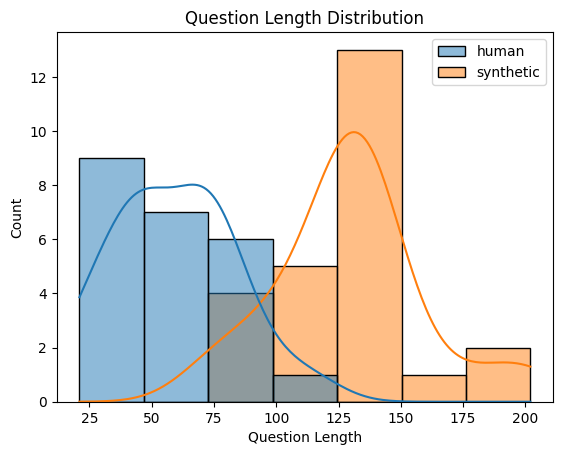

In [ ]:
#Compare question lengths.
questionLength = {"human": human_evalData["question"].map(len),
                  "synthetic": synthetic_evalData["question"].map(len)}

sns.histplot(questionLength, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")
plt.show()

In [ ]:
#Combine human and synthetic evaluation data.
eval_df = pd.concat([human_evalData, synthetic_evalData], ignore_index=True)
#Add is_synthetic column.
eval_df["is_synthetic"] = eval_df["relevant_section"].isna()
#Show counts of synthetic and human entries.
print(eval_df["is_synthetic"].value_counts())

is_synthetic
False    25
True     23
Name: count, dtype: int64


# **RAGAS Metrics.**

In [ ]:
def get_or_create_evalDataset(name: str, data: pd.DataFrame, chain: Chain) -> Dataset:
  '''Generate an evaluation dataset in memory based on a DataFrame and a Chain.'''

  print(f"Generating {name} dataset in memory...")
  datapoints = {
        "question": data["question"].tolist(),
        "answer": [],
        "contexts": [],
        "ground_truth": data["ground_truth"].tolist(),
        "context_urls": []    }

  for question in tqdm(datapoints["question"], desc=f"Processing {name}"):
    result = chain.invoke(question)
    datapoints["answer"].append(result["answer"])
    datapoints["contexts"].append([str(doc.page_content) for doc in result["context"]])
    datapoints["context_urls"].append([doc.metadata["url"] for doc in result["context"]])

  dataset = Dataset.from_dict(datapoints)
  print(f"Generated {name} dataset with {len(datapoints['question'])} entries.")
  return dataset

In [ ]:
def run_llmEval(name: str, dataset: Dataset, llm_judge_model: LLM) -> pd.DataFrame:
  '''Run LLM-based evaluation on a given dataset, including RAGAS metrics, ROUGE-1, ROUGE-2, Perplexity, and BERTScore.'''
  print(f"Running LLM evaluation for {name} in memory...")

  #RAGAS evaluation.
  ragasResults = evaluate(
    dataset,
    metrics=[faithfulness, answer_relevancy, context_relevancy, answer_correctness],
    is_async=True,
    llm=llm_judge_model,
    embeddings=embeddingModels[name.split("_")[0]],
    run_config=RunConfig(
            timeout=60, max_retries=10, max_wait=60, max_workers=8)).to_pandas()

  #Metric results.
  rouge1Scores = []
  rouge2Scores = []
  perplexities = []
  bert_scorePrecisions = []
  bert_scoreRecalls = []
  bert_scoreF1s = []

  for i, entry in enumerate(dataset):
    question = entry["question"]
    groundTruth = entry["ground_truth"]
    generatedAnswer = ragasResults.loc[i, "answer"]

    #ROUGE scores.
    rougeScores = global_rouge_scorer.score(groundTruth, generatedAnswer)
    rouge1Scores.append(rougeScores['rouge1'].fmeasure)
    rouge2Scores.append(rougeScores['rouge2'].fmeasure)

    #Perplexity.
    input_ids = global_tokenizer.encode(generatedAnswer, return_tensors="pt")
    with torch.no_grad():
      loss = global_gpt2_model(input_ids, labels=input_ids).loss
    perplexity = torch.exp(loss)
    perplexities.append(perplexity.item())

    #BERTScore.
    precision, recall, f1 = bert_score([generatedAnswer], [groundTruth], lang="en", verbose=False)
    bert_scorePrecisions.append(precision.mean().item())
    bert_scoreRecalls.append(recall.mean().item())
    bert_scoreF1s.append(f1.mean().item())

  #Include all metrics.
  ragasResults["rouge1"] = rouge1Scores
  ragasResults["rouge2"] = rouge2Scores
  ragasResults["perplexity"] = perplexities
  ragasResults["bert_score_precision"] = bert_scorePrecisions
  ragasResults["bert_score_recall"] = bert_scoreRecalls
  ragasResults["bert_score_f1"] = bert_scoreF1s

  print(f"Completed LLM evaluation for {name} with {len(ragasResults)} results.")
  return ragasResults

In [ ]:
def plot_multipleEvals(eval_results_byK: Dict[int, Dict[str, pd.Series]], selectedMetrics=None):
  """Plot evaluation results (mean and median) for:
    'faithfulness', 'answer_relevancy', 'context_relevancy', 'answer_correctness'."""

  if selectedMetrics is None:
    selectedMetrics = ['faithfulness', 'answer_relevancy', 'context_relevancy', 'answer_correctness']

  fullResults = []
  for k, evalResults in eval_results_byK.items():
    combinedResults = {}
    for name, results in evalResults.items():
      if isinstance(results, pd.Series):
        combinedResults[name] = results
    if combinedResults:
      resultsData = pd.DataFrame(combinedResults)
      resultsData['k'] = k
      fullResults.append(resultsData)
    else:
      print(f"No valid results for k={k}")

  if not fullResults:
    raise ValueError("No valid DataFrame objects found in evalResults.")

  fullResults = pd.concat(fullResults, ignore_index=True)
  #Filter and melt data.
  ragas_metricsData = fullResults[selectedMetrics + ['k']]
  meltedData = pd.melt(ragas_metricsData, id_vars=['k'], var_name='Metric', value_name='Score')

  def plotGrouped(data, title, y_label):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Score', hue='k', data=data, palette="Set2")
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='k', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

  #Mean metrics.
  means = meltedData.groupby(['k', 'Metric']).mean().reset_index()
  plotGrouped(means, 'Mean of Selected Evaluation Metrics by k Value', 'Mean Scores')

  #Median metrics
  medians = meltedData.groupby(['k', 'Metric']).median().reset_index()
  plotGrouped(medians, 'Median of Selected Evaluation Metrics by k Value', 'Median Scores')

In [ ]:
def plot_extendedEvals(eval_results_byK: Dict[int, Dict[str, pd.Series]], selectedMetrics=None):
  """Plot evaluation results (mean and median) for:
    'rouge1', 'rouge12', 'perplexity', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1'."""

  if selectedMetrics is None:
        selectedMetrics = ["rouge1", "rouge2", "perplexity", "bert_score_precision", "bert_score_recall", "bert_score_f1"]

  fullResults = []
  for k, evalResults in eval_results_byK.items():
    combinedResults = {}
    for name, results in evalResults.items():
      if isinstance(results, pd.Series):
        combinedResults[name] = results
    if combinedResults:
      resultsData = pd.DataFrame(combinedResults)
      resultsData['k'] = k
      fullResults.append(resultsData)
    else:
            print(f"No valid results for k={k}")

  if not fullResults:
    raise ValueError("No valid DataFrame objects found in evalResults.")

  fullResults = pd.concat(fullResults, ignore_index=True)
  #Perplexity plot individually due to larger range.
  perplexityData = fullResults[['perplexity', 'k']].dropna()
  otherMetrics = [metric for metric in selectedMetrics if metric != 'perplexity']
  otherMetrics_data = fullResults[otherMetrics + ['k']].dropna()
  #Melt data.
  meltedData = pd.melt(otherMetrics_data, id_vars=['k'], var_name='Metric', value_name='Score')

  def plotGrouped(data, title, y_label):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Score', hue='k', data=data, palette="Set2")
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='k', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

  #Plot mean and median for other metrics.
  means = meltedData.groupby(['k', 'Metric']).mean().reset_index()
  plotGrouped(means, 'Mean of Selected Evaluation Metrics (Excluding Perplexity)', 'Mean Scores')
  medians = meltedData.groupby(['k', 'Metric']).median().reset_index()
  plotGrouped(medians, 'Median of Selected Evaluation Metrics (Excluding Perplexity)', 'Median Scores')

  #Plot perplexity separately.
  def plotPerplexity(data, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='k', y='perplexity', data=data, palette="Set2")
    plt.title(title)
    plt.ylabel('Perplexity')
    plt.xlabel('k Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

  #Plot perplexity mean and median
  perplexityMean = perplexityData.groupby('k')['perplexity'].mean().reset_index()
  plotPerplexity(perplexityMean, 'Mean Perplexity by k Value')
  perplexityMedian = perplexityData.groupby('k')['perplexity'].median().reset_index()
  plotPerplexity(perplexityMedian, 'Median Perplexity by k Value')

## **Dataset Generation.**

In [ ]:
datasets_byK = {}

for k, chains in chains_byK.items():
  datasets = {}
  print(f"Generating datasets for k={k}...")

  for collectionName, chain in chains.items():
    datasetName = f"{collectionName}_k{k}"
    datasets[datasetName] = get_or_create_evalDataset(datasetName, evalData, chain)
  datasets_byK[k] = datasets

### **Write + Read Dataset generation.**

*   Took 1 hour to run so we can go back retrieve the result later.

In [ ]:
#Write.
serializable_datasets_byK = {
    k: {name: dataset.to_dict() for name, dataset in datasets.items()}
    for k, datasets in datasets_byK.items()}
with open("datasets_byK.json", "w") as file:
  json.dump(serializable_datasets_byK, file)
print("Successfully saved datasets_byK to datasets_byK.json!")

Successfully saved datasets_byK to datasets_byK.json.!


In [ ]:
#Read.
try:
  with open("datasets_byK.json", "r") as file:
    serialized_data = json.load(file)
  datasets_byK_readIn = {
        int(k): {name: Dataset.from_dict(data) for name, data in datasets.items()}
        for k, datasets in serialized_data.items()}
  print("datasets_byK_readIn loaded successfully!")
except FileNotFoundError:
  print("datasets_byK.json not found. Please generate the datasets.")

datasets_byK_readIn loaded successfully!


## **Dataset Evaluation.**

### **k = 1.**

In [ ]:
eval_resultsK1 = {}
print("Evaluating chains for k=3...")
datasetsK1 = datasets_byK_readIn[1]

for dataset_name, dataset in datasetsK1.items():
  eval_resultsK1[dataset_name] = run_llmEval(dataset_name, dataset, llm)
print(f"Evaluation for k=1 completed. Results: {list(eval_resultsK1.keys())}")

In [ ]:
def convert_ndarray_to_list(obj):
  '''Convert so output can be written to a json file.'''
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, dict):
    return {key: convert_ndarray_to_list(value) for key, value in obj.items()}
  elif isinstance(obj, list):
    return [convert_ndarray_to_list(item) for item in obj]
  else:
    return obj

In [ ]:
#Write.
serializable_eval_results1 = {
    dataset_name: convert_ndarray_to_list(results.to_dict())
    for dataset_name, results in eval_resultsK1.items()}

with open("eval_results_k1.json", "w") as file:
    json.dump(serializable_eval_results1, file, indent=4)
print("Evaluation results for k=1 saved to eval_results_k1.json!")

Evaluation results for k=1 saved to eval_results_k1.json!


In [ ]:
#Read.
with open("eval_results_k1.json", "r") as file:
  loadedData = json.load(file)

eval_resultsK1_readIn = {
    dataset_name: pd.DataFrame.from_dict(results)
    for dataset_name, results in loadedData.items()}
print("Successfully loaded eval_resultsK1!")

Successfully loaded eval_resultsK1!


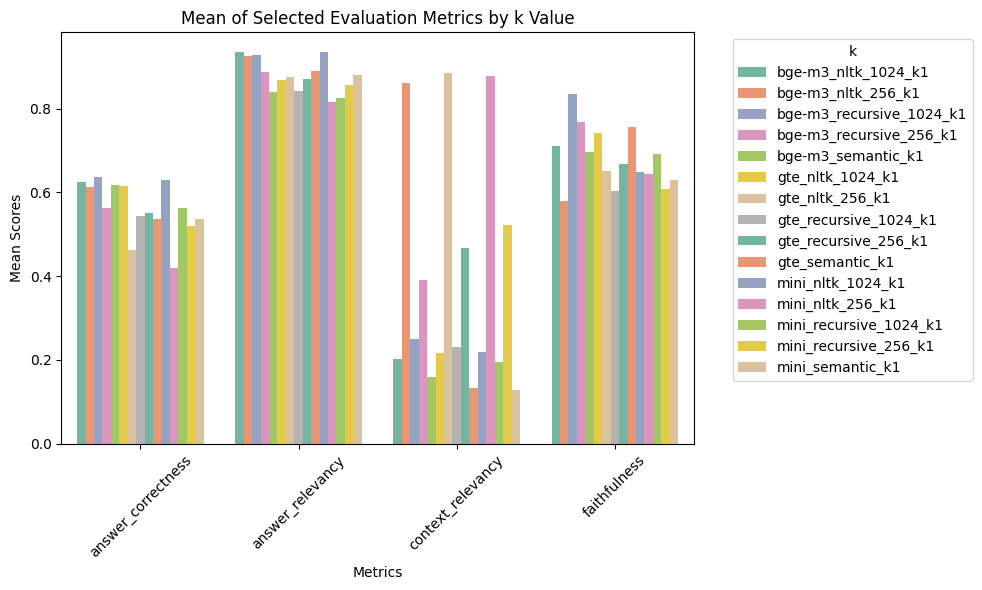

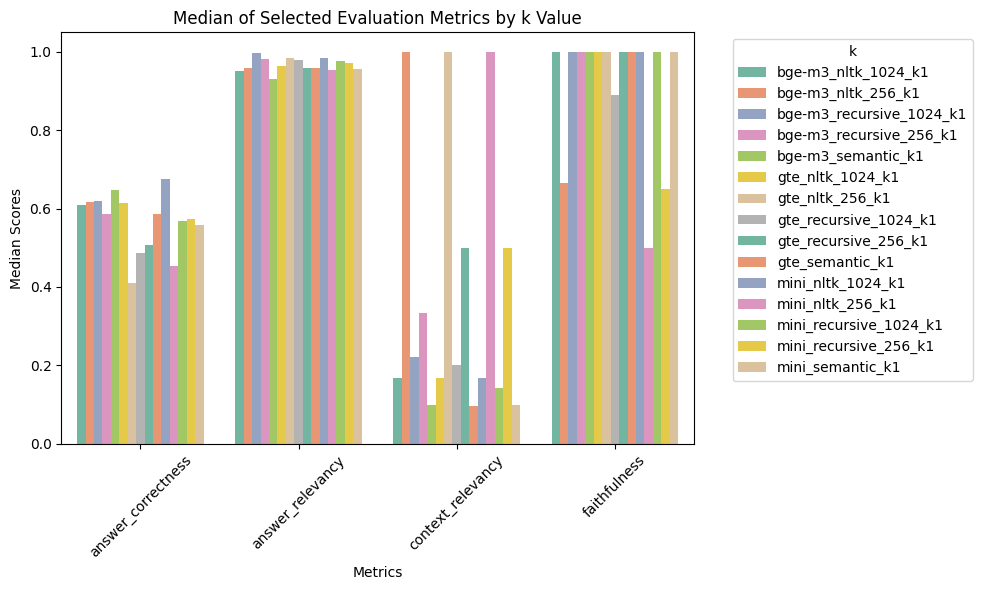

In [ ]:
#Plot the results.
plot_multipleEvals(eval_resultsK1)

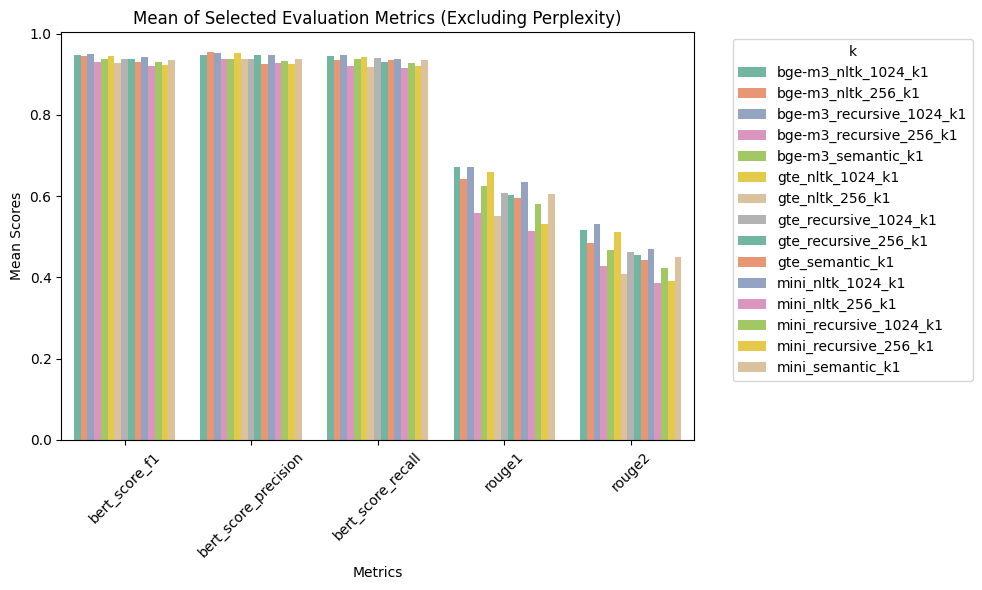

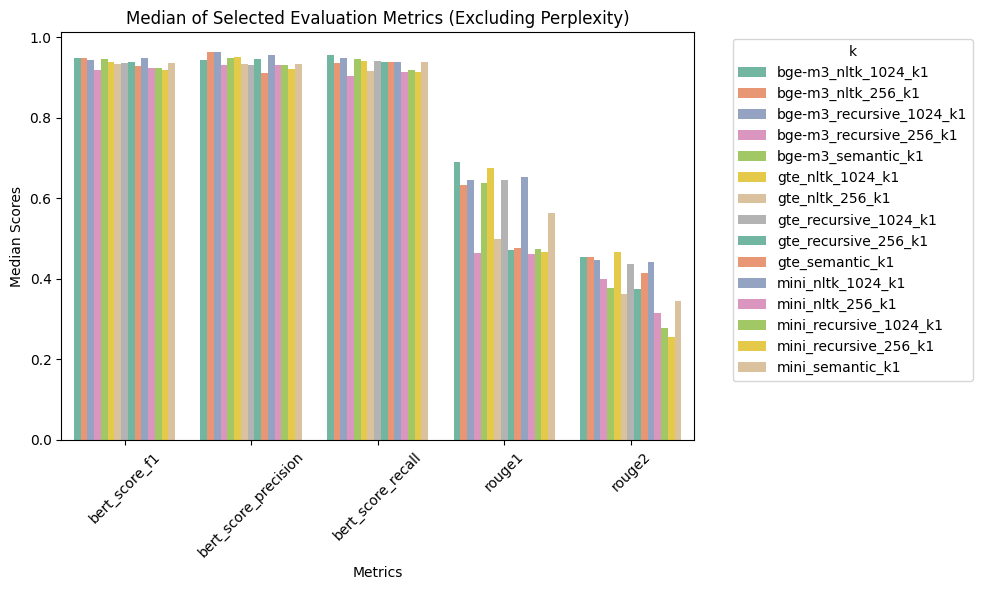

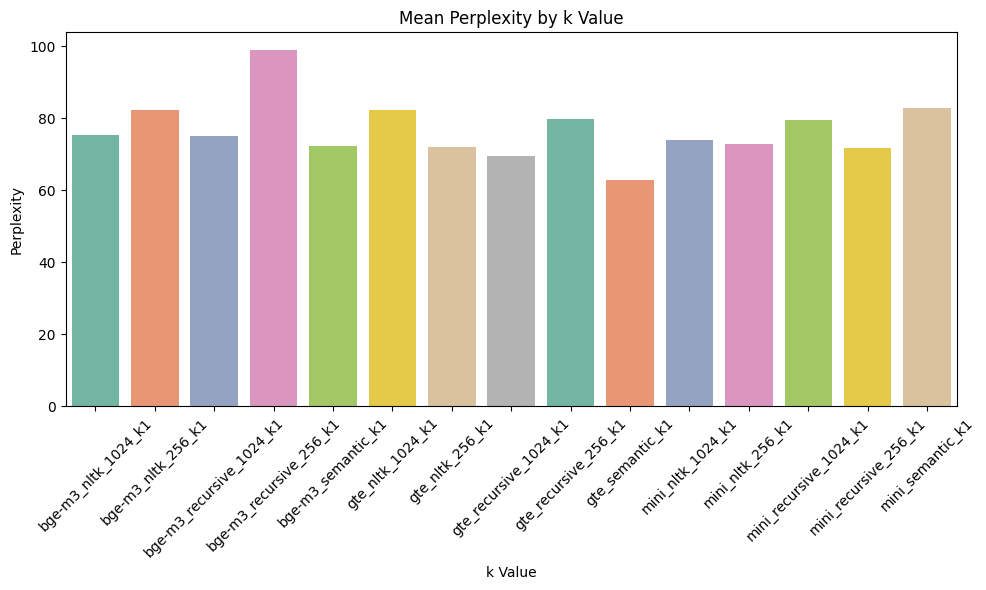

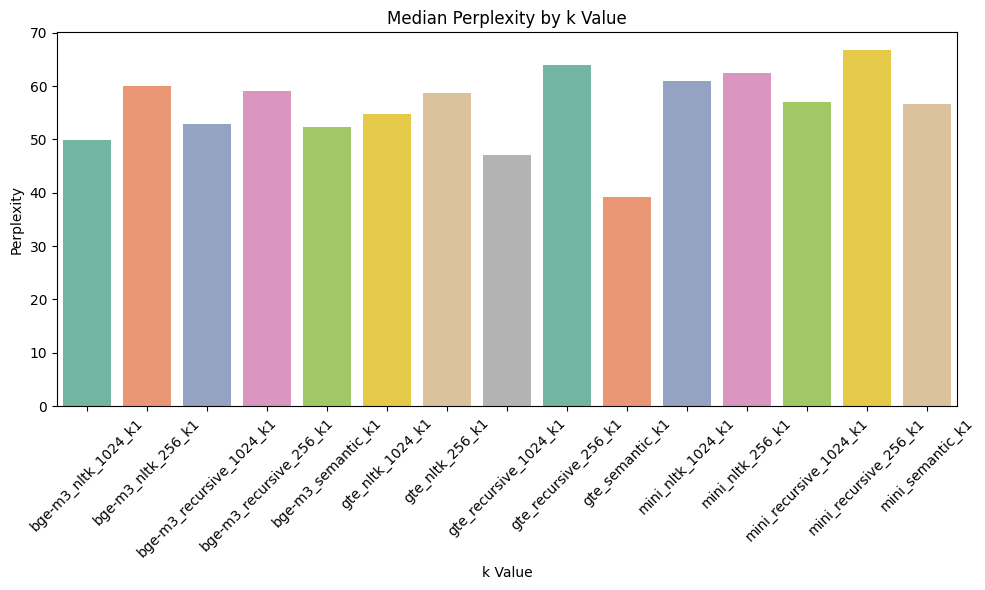

In [ ]:
#Plot the results.
plot_extendedEvals(eval_resultsK1)

### **k = 3.**

In [ ]:
eval_resultsK3 = {}
print("Evaluating chains for k=3...")
datasetsK3 = datasets_byK_readIn[3]

for dataset_name, dataset in datasetsK3.items():
  eval_resultsK3[dataset_name] = run_llmEval(dataset_name, dataset, llm)
print(f"Evaluation for k=3 completed. Results: {list(eval_resultsK3.keys())}")

In [ ]:
#Write.
serializable_eval_results3 = {
    dataset_name: convert_ndarray_to_list(results.to_dict())
    for dataset_name, results in eval_resultsK3.items()}

with open("eval_results_k3.json", "w") as file:
    json.dump(serializable_eval_results3, file, indent=4)
print("Evaluation results for k=3 saved to eval_results_k3.json!")

Evaluation results for k=3 saved to eval_results_k3.json!


In [ ]:
#Read.
with open("eval_results_k3.json", "r") as file:
  loadedData = json.load(file)

eval_resultsK3_readIn = {
    dataset_name: pd.DataFrame.from_dict(results)
    for dataset_name, results in loadedData.items()}
print("Successfully loaded eval_resultsK3!")

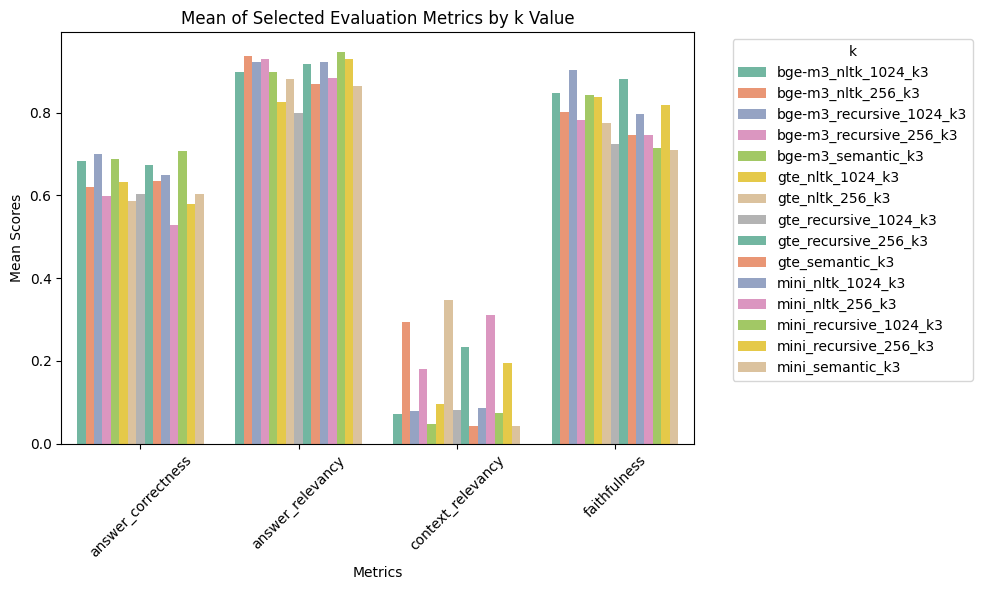

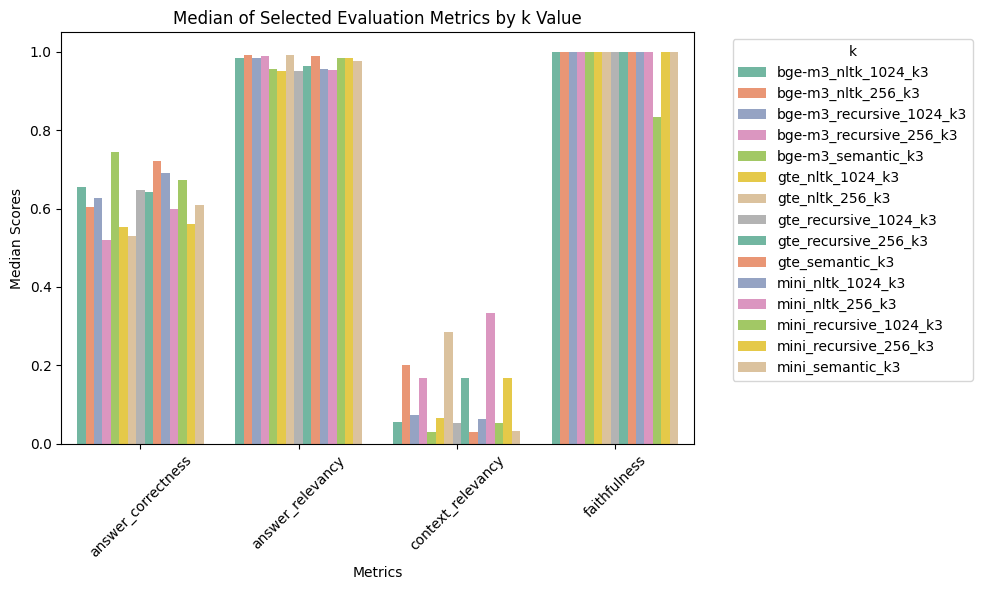

In [ ]:
#Plot the results.
plot_multipleEvals(eval_resultsK3)

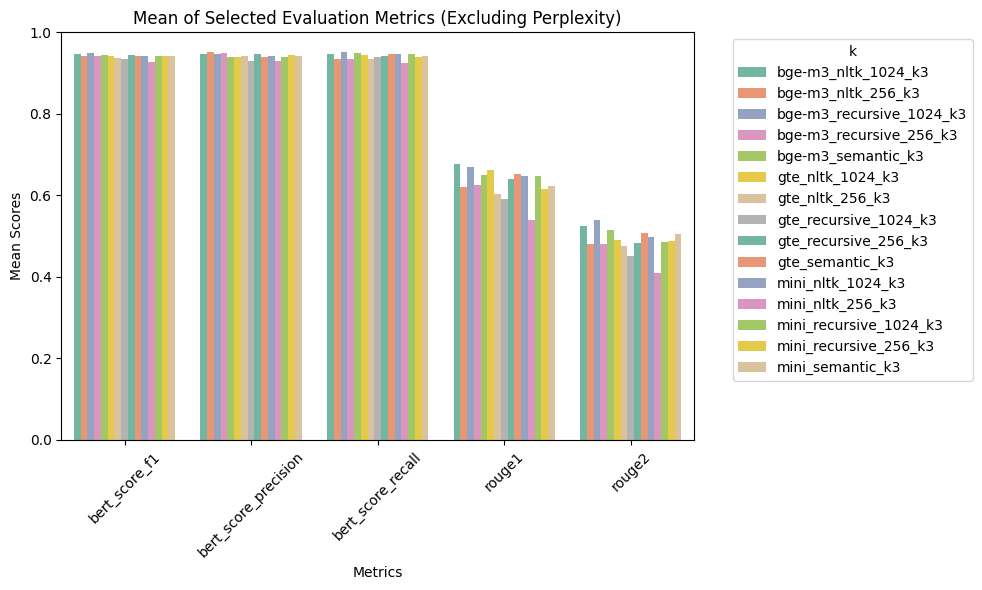

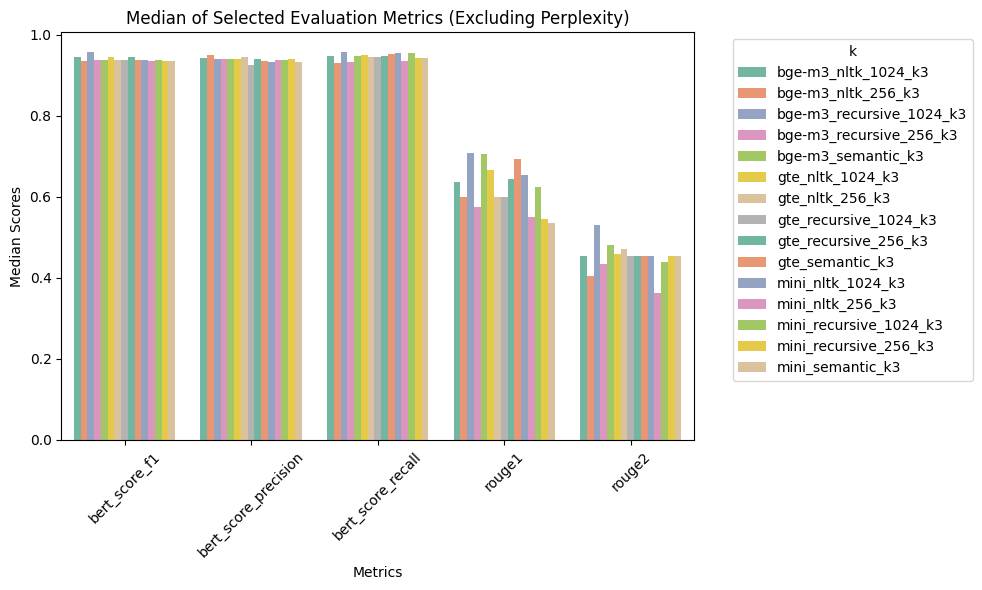

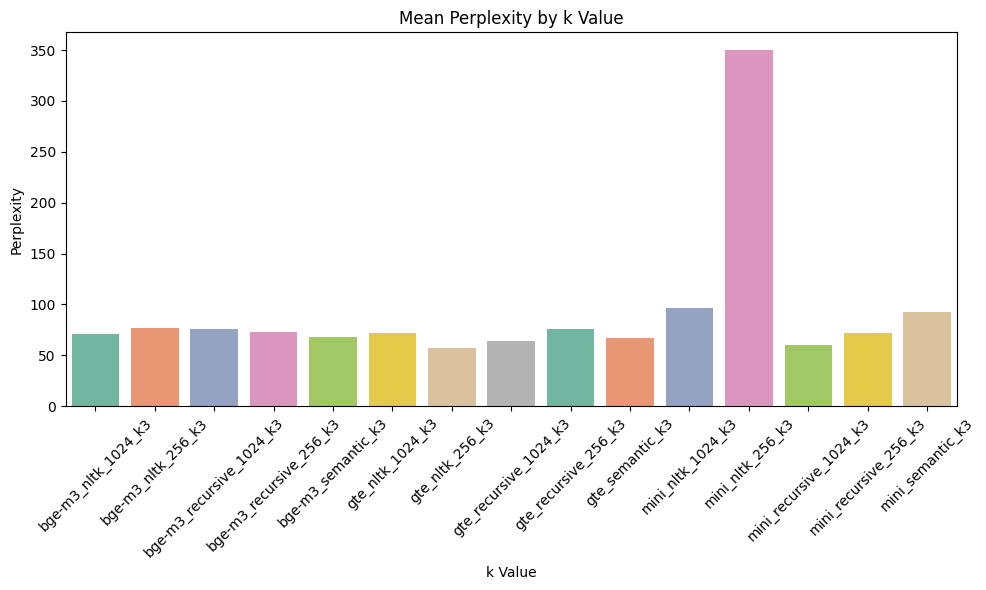

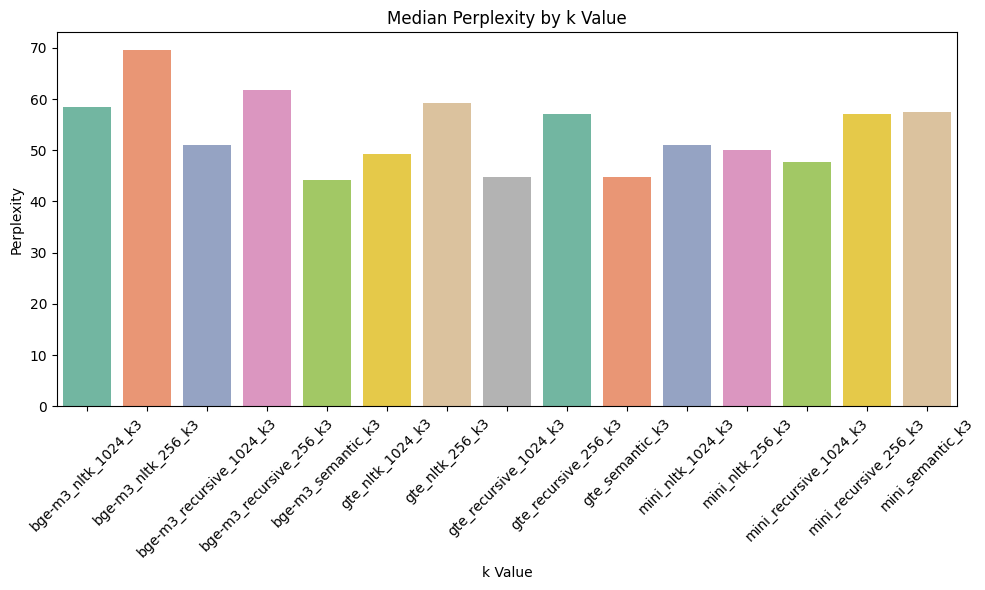

In [ ]:
plot_extendedEvals(eval_resultsK3)

### **k = 5.**

In [ ]:
eval_resultsK5 = {}
print("Evaluating chains for k=5...")
datasetsK5 = datasets_byK_readIn[5]

for dataset_name, dataset in datasetsK5.items():
  eval_resultsK5[dataset_name] = run_llmEval(dataset_name, dataset, llm)
print(f"Evaluation for k=5 completed. Results: {list(eval_resultsK5.keys())}")

In [ ]:
#Write.
serializable_eval_results5 = {
    dataset_name: convert_ndarray_to_list(results.to_dict())
    for dataset_name, results in eval_resultsK5.items()}

with open("eval_results_k5.json", "w") as file:
    json.dump(serializable_eval_results3, file, indent=4)
print("Evaluation results for k=5 saved to eval_results_k5.json!")

Evaluation results for k=5 saved to eval_results_k5.json!


In [ ]:
#Read.
with open("eval_results_k5.json", "r") as file:
  loadedData = json.load(file)

eval_resultsK5_readIn = {
    dataset_name: pd.DataFrame.from_dict(results)
    for dataset_name, results in loadedData.items()}
print("Successfully loaded eval_resultsK5!")

Successfully loaded eval_resultsK5!


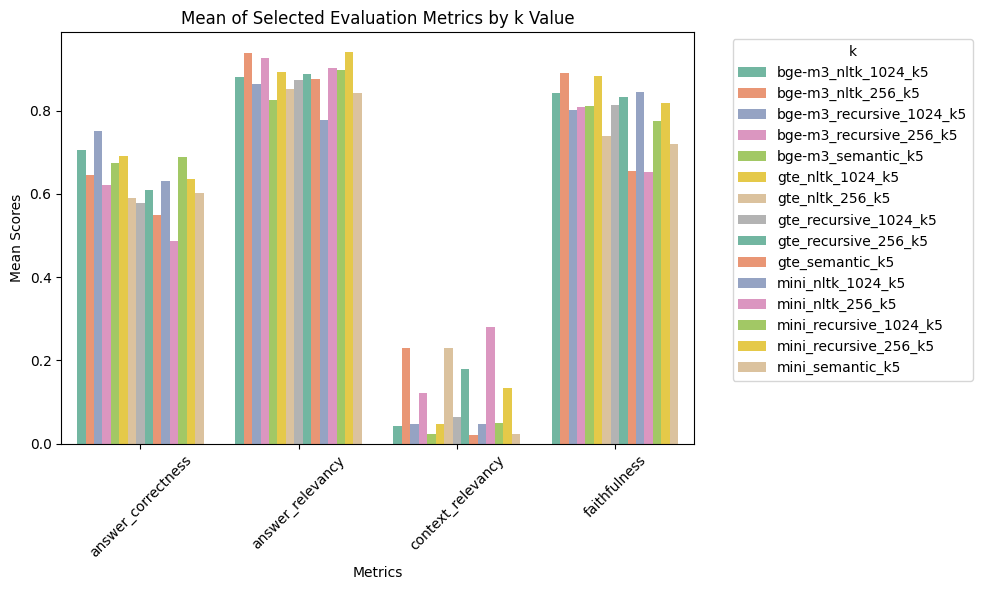

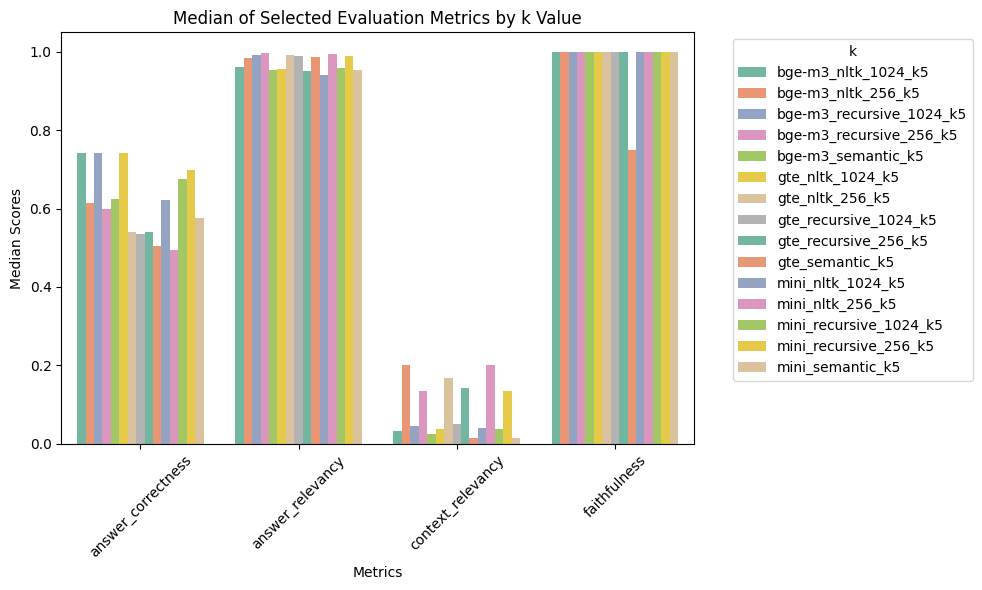

In [ ]:
#Plot the results.
plot_multipleEvals(eval_resultsK5)

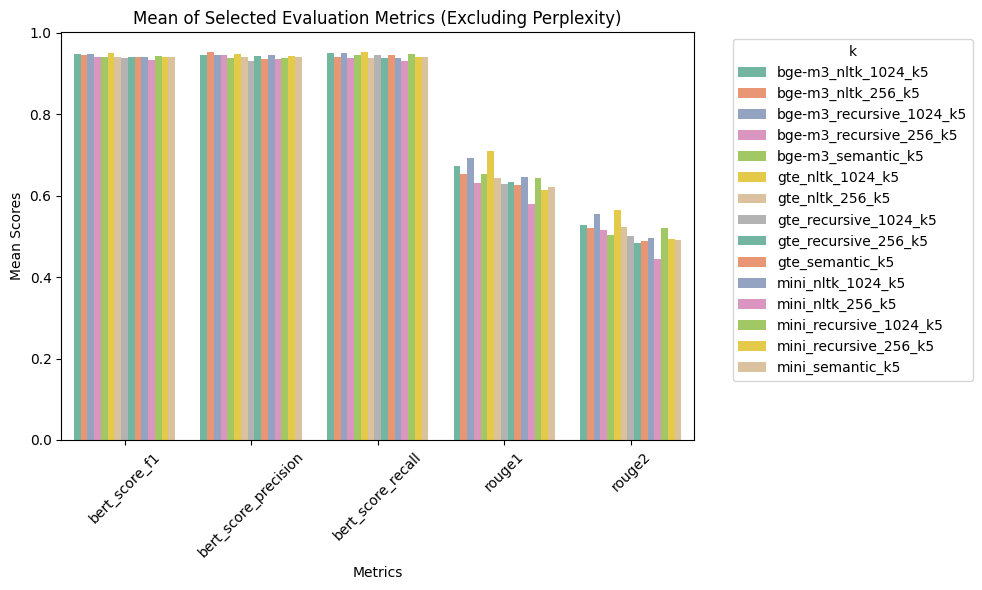

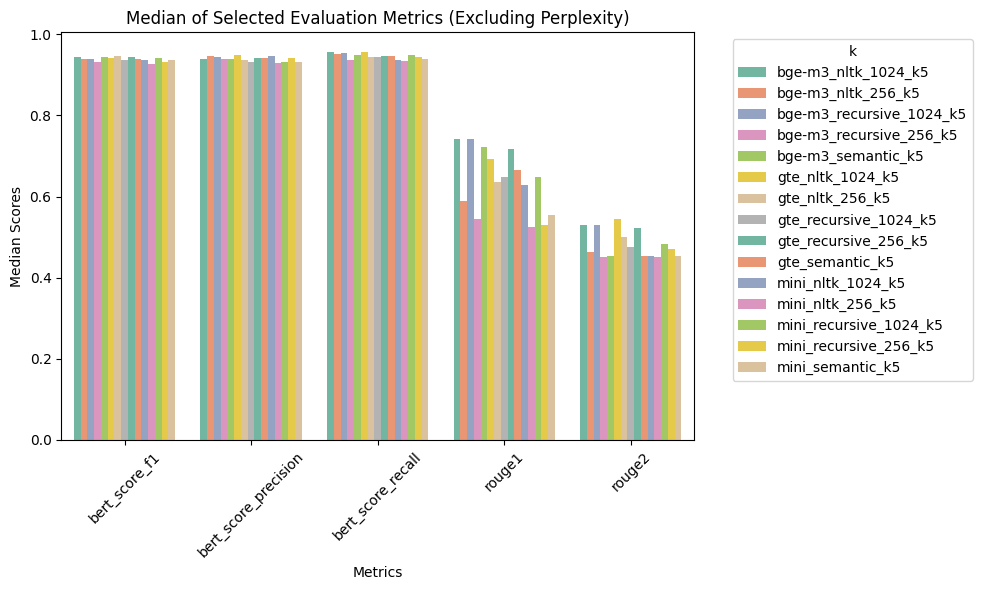

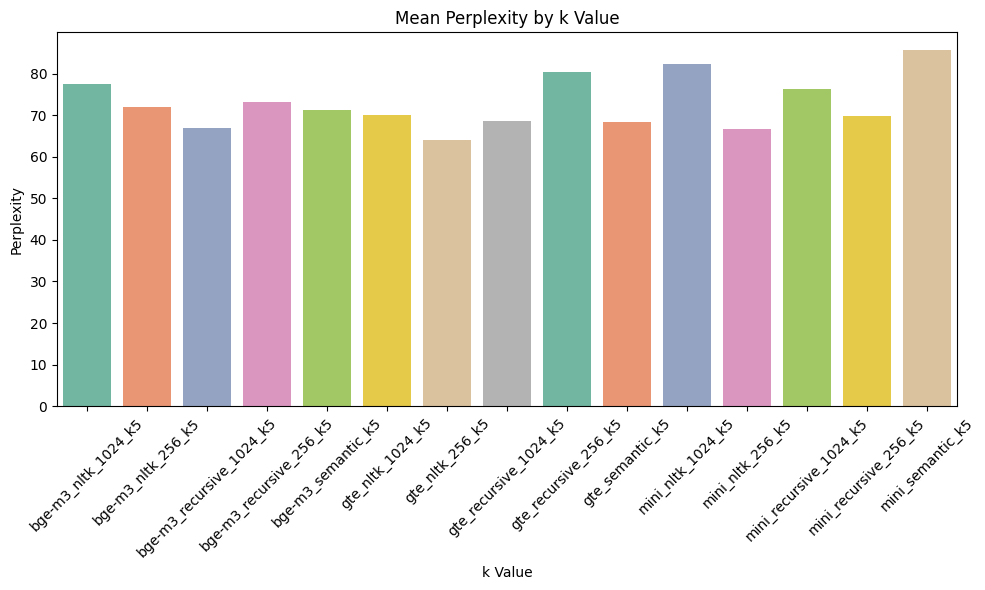

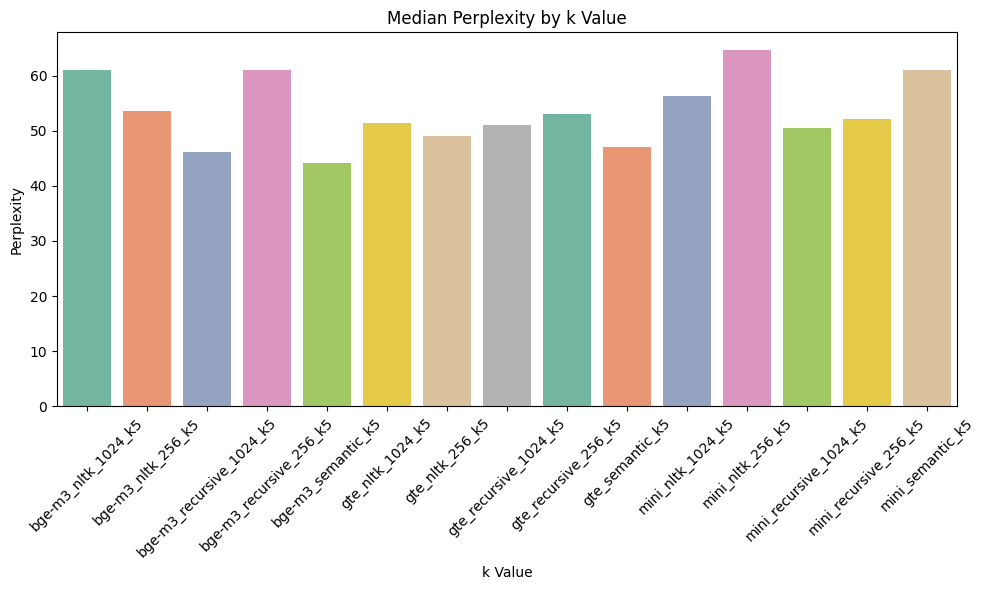

In [ ]:
plot_extendedEvals(eval_resultsK5)

**Write to a PDF File.**

In [103]:
#!apt-get -qq install -y pandoc > /dev/null 2>&1
#!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
#!apt-get update > /dev/null 2>&1
#!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert --to pdf "/content/drive/MyDrive/CSC583/CSC583 - Final Project.ipynb" > /dev/null 2>&1